# Figure 6: Assess CLARC impact on post-vaccination prediction using a quadratic programming (QP) model

### Import/install necessary packages

In [1]:
%load_ext rpy2.ipython

In [2]:
import pandas as pd
import numpy as np
import scipy as scipy
import sys
import random
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
import matplotlib.pyplot as plt
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import os
import seaborn as sns
import matplotlib.lines as mlines

### Functions for QP Tests

In [31]:
%%R 
# Import necessary R packages
require(tidyverse)
require(quadprog)
require(pracma)
require(cowplot)
require(ggrepel)
require(magrittr)
require(corrplot)
require(psych)
require(gridExtra)
require(RColorBrewer)
require(lazyeval)
setwd("~/R_functions/") # Include directory where you put the R functions

In [4]:
# Load R functions from separate files into python
# R functions can be found at https://github.com/IndraGonz/2024_GonzalezOjeda_CLARC/tree/main/Figures/Fig6/code

# Quadratic programming function
r_source = robjects.r['source']
r_source('~/R_functions/QP.R')
r_QP = robjects.globalenv['QP']

# Inputs need to be *Numpy Arrays*

# Function to plot QP output
r_source = robjects.r['source']
r_source('~/R_functions/plotPred.R')
r_plotPred = robjects.globalenv['plotPred']

# Input is a dataframe with 4 columns:
# "GPSC" = strain classification, can be any classification doesn't have to necessarily be GPSC
# "vaccine" = vaccine type of the strain, either VT or NVT
# "SC_obs" = strain prevalences that were observed in the population
# "SC_pred" = strain prevalences that were predicted with the QP model

# Function to get SSE number for prediction
r_source = robjects.r['source']
r_source('~/R_functions/SSEpred.R')
r_SSEpred = robjects.globalenv['SSEpred']

# Input is the same as plotPred

## Function for QP testing giving CLARC acc COG matrices as input

In [32]:
# GPSC metadata file can be found at https://github.com/IndraGonz/2024_GonzalezOjeda_CLARC/tree/main/Figures/Fig6/data

def get_qp_sse(acc_pres_abs_path):

    #### Import data
        
    # Import datafile with accessory gene info
    pan_acc = pd.read_csv(acc_pres_abs_path, low_memory=False)
    
    # Rename first column to Accession in the case of CLARC presence absence matrices
    if pan_acc.columns[0] != 'Isolate Name':
        pan_acc.rename(columns={pan_acc.columns[0]: 'Isolate Name'}, inplace=True)
    
    # Import metadata
    meta = pd.read_csv('~/new_gpsc_metadata_MMN.csv')
    
    # Add metadata to presence absence matrix
    pan_acc = pd.merge(pan_acc, meta, on='Isolate Name')
    
    # Get only Navajo dataset
    navajo_pan_acc = pan_acc[pan_acc['Population']=='Navajo']
    
    # Add vaccine type column
    navajo_pan_acc.insert(7, 'PCV7_vaccine_type', "NVT")
    # Determine vaccine using previously outlined cutoffs
    navajo_pan_acc.loc[(navajo_pan_acc['serotype'] == '4') | (navajo_pan_acc['serotype'] == '6A') | (navajo_pan_acc['serotype'] == '6B') | (navajo_pan_acc['serotype'] == '9V') | (navajo_pan_acc['serotype'] == '14') | (navajo_pan_acc['serotype'] == '18C') | (navajo_pan_acc['serotype'] == '19F') | (navajo_pan_acc['serotype'] == '23F'), 'PCV7_vaccine_type'] = 'VT'
    
    # Changing 'year' datatype to numeric, to do logical operations
    navajo_pan_acc['Year of Isolation'] = navajo_pan_acc.loc[:,'Year of Isolation'].astype('int64')
    
    # Add Epoch column
    navajo_pan_acc.insert(4, 'epoch', " ")
    
    # Determine epoch using previously outlined cutoffs
    navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 1998) & (navajo_pan_acc['Year of Isolation'] <= 2001), 'epoch'] = 'E1'
    navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 2006) & (navajo_pan_acc['Year of Isolation'] <= 2008), 'epoch'] = 'E2'
    navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 2010) & (navajo_pan_acc['Year of Isolation'] <= 2012), 'epoch'] = 'E3'
    
    # Get datasets per epoch
    navajo_e1 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E1'].copy()
    navajo_e2 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E2'].copy()
    navajo_e3 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E3'].copy()
    
    #### Preparing data for QP test
    
    # Let's check which GPSCs are mixed, which are VT and which are NVT
    
    # First let's sort by GPSC
    navajo_all_gpsc = navajo_pan_acc.sort_values(by='GPSC')
    
    # Now let's group by GPSC, and then loop through each group to see which GPSC are VT, NVT, or mixed
    navajo_all_grouped_gpsc = navajo_pan_acc.groupby(['GPSC'])
    
    # There is a total of 68 GPSCs in the Navajo dataset
    
    # Next, checks if GPSC is mixed (contains both VT and NVT isolates). True = It is mixed, False = It is not mixed
    navajo_all_gpsc_ismixed = navajo_pan_acc.groupby(['GPSC']).PCV7_vaccine_type.apply(lambda x: len(set(x)) != 1)
    
    # There are 61 pure GPSCs and 7 mixed GPSCs accross all epochs
    
    # Get mixed GPSCs
    mixed_gpsc = navajo_all_gpsc_ismixed[navajo_all_gpsc_ismixed == True]
    mixed_gpsc_list = list(mixed_gpsc.index)
    
    # The mixed GPSCs are: 13, 16, 18, 6, 633, 7, 904;9
    
    # 119 is VT
    
    # Now let's group E3 by GPSC
    navajo_e3_grouped_gpsc = navajo_e3.groupby(['GPSC'])
    
    # What GPSCs appear at E3?
    navajo_e3_gpsc_ismixed = navajo_e3.groupby(['GPSC']).PCV7_vaccine_type.apply(lambda x: len(set(x)) != 1)
    
    # 43 GPSCs appear at E3
    
    # Calculating M input for each population
    
    # Now, let's calculate the observed COG frequencies per GPSC
    # (this will be the first part of the input, of the population for which strain frequencies are being calculated)
    
    # First we get rid of the unnecessary columns
    
    # Navajo all epochs
    navajo_all_f = navajo_pan_acc.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])
    
    # Navajo E1
    navajo_e1_f = navajo_e1.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])
    
    #Navajo E2
    navajo_e2_f = navajo_e2.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])
    
    #Navajo E3
    navajo_e3_f = navajo_e3.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])
    
    # Now we determine the frequency of each COG per GPSC
    #(and we transpose + sort by alphabetical order for consistency with QP function input)
    
    # Important: Only the GPSCs that contain >5 isolates in the Navajo dataset to be predicted are being taken into account here, all others are dropped
    
    # Navajo E1
    navajo_e1_freq = navajo_e1_f.groupby(['GPSC']).mean()
    navajo_e1_freq = navajo_e1_freq.transpose()
    navajo_e1_freq = navajo_e1_freq.sort_index(axis=0)
    navajo_e1_freq = navajo_e1_freq.reset_index()
    navajo_e1_freq = navajo_e1_freq.rename(columns={"index": "COG_identifier"})
    navajo_e1_freq = navajo_e1_freq.rename_axis(None, axis=1)
    
    # Navajo E2
    navajo_e2_freq = navajo_e2_f.groupby(['GPSC']).mean()
    navajo_e2_freq = navajo_e2_freq.transpose()
    navajo_e2_freq = navajo_e2_freq.sort_index(axis=0)
    navajo_e2_freq = navajo_e2_freq.reset_index()
    navajo_e2_freq = navajo_e2_freq.rename(columns={"index": "COG_identifier"})
    navajo_e2_freq = navajo_e2_freq.rename_axis(None, axis=1)
    
    # Navajo E3
    navajo_e3_freq = navajo_e3_f.groupby(['GPSC']).mean()
    navajo_e3_freq = navajo_e3_freq.transpose()
    navajo_e3_freq = navajo_e3_freq.sort_index(axis=0)
    navajo_e3_freq = navajo_e3_freq.reset_index()
    navajo_e3_freq = navajo_e3_freq.rename(columns={"index": "COG_identifier"})
    navajo_e3_freq = navajo_e3_freq.rename_axis(None, axis=1)
    
    # Calculating E input for each population
    
    # Now to determine global COG frequencies (not per strain)
    # (this is the second input of the QP function, for the population that is being used to predict strain frequencies)
    
    # Navajo E1
    navajo_e1_gf = navajo_e1.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
    navajo_e1_gfreq = navajo_e1_gf.mean()
    navajo_e1_gfreq = navajo_e1_gfreq.sort_index(axis=0)
    
    # Navajo E2
    navajo_e2_gf = navajo_e2.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
    navajo_e2_gfreq = navajo_e2_gf.mean()
    navajo_e2_gfreq = navajo_e2_gfreq.sort_index(axis=0)
    
    # Navajo E3
    navajo_e3_gf = navajo_e3.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
    navajo_e3_gfreq = navajo_e3_gf.mean()
    navajo_e3_gfreq = navajo_e3_gfreq.sort_index(axis=0)
    
    # Preparing the input for QP result plotting function (in each population)
    
    # Finally, let's calculate the observed strain prevalences for each population
    # (These are the values against which the QP predictions will be compared)
    # To be input into the function, the output of the QP model must be appended to these dataframes under the name "SC_pred"
    
    # Navajo all
    
    # Only get GPSC info
    navajo_all_gpsc = navajo_pan_acc[['GPSC']]
    
    # Count number of isolates in each GPSC
    navajo_all_gpscount = navajo_all_gpsc.groupby(['GPSC']).value_counts()
    navajo_all_gpscount = navajo_all_gpscount.reset_index()
    navajo_all_gpscount.columns = ["GPSC","GPSC_count"]
    
    # Drop GPSCs that have 5 or less isolates
    navajo_all_gpscount = navajo_all_gpscount.loc[navajo_all_gpscount["GPSC_count"] > 5 ]
    
    # Get list of GPSCs with <= 5 isolates accross all epochs
    navajo_over5_alle = list(navajo_all_gpscount['GPSC'])
    
    # Get list of GPSCs at E3
    navajo_e3_freq_index = navajo_e3_freq.set_index(navajo_e3_freq.columns[0])
    navajo_gpsc_e3 = list(navajo_e3_freq_index.columns)
    
    # Get intersect of these lists
    navajo_e3_over5 = list(set(navajo_over5_alle) & set(navajo_gpsc_e3))
    
    # Calculate frequencies
    
    #Drop isolates not in the needed GPSCs
    navajo_e3_need_gpsc = navajo_e3[navajo_e3.GPSC.isin(navajo_e3_over5)]
    
    # Only get GPSC info
    navajo_e3_gpsc = navajo_e3_need_gpsc[['GPSC']]
    
    # Count number of isolates in each GPSC
    navajo_e3_gpscount = navajo_e3_gpsc.groupby(['GPSC']).value_counts()
    navajo_e3_gpscount = navajo_e3_gpscount.reset_index()
    navajo_e3_gpscount.columns = ["GPSC","GPSC_count"]
    
    # Now, calculate the frequency 
    navajo_e3_total = navajo_e3_gpscount['GPSC_count'].sum()
    navajo_e3_gpscount['GPSC_freq'] = navajo_e3_gpscount['GPSC_count']/navajo_e3_total
    
    # Finally, create dataframe in the format that the QP plot function takes
    pred_navajo_e3 = navajo_e3_gpscount.drop(columns=['GPSC_count'])
    pred_navajo_e3.insert(1, 'vaccine', "NVT") # This is MEANINGLESS, it's not actually making a distinction between NVT, mixed and VT. But it needs to have this format to go into the function.
    pred_navajo_e3 = pred_navajo_e3.rename(columns={"GPSC_freq": "SC_obs"})
    
    # Switch the mixed GPSCs to mixed (these are 13, 16, 18, 6, 633, 7, 904;9)
    rows_loop = pred_navajo_e3.shape[0]
    
    for i in range(rows_loop):
        value = pred_navajo_e3.loc[i, 'GPSC']
        
        if value in mixed_gpsc_list:       
            pred_navajo_e3.loc[i, 'vaccine'] = 'mixed'
    
        if value == '119':
            pred_navajo_e3.loc[i, 'vaccine'] = np.nan
    
    # Preparing for QP function - Dropping GPSC groups with < 5 isolates from M matrix
    
    # Now, finally, since we are only predicting the GPSC with > 5 isolates in the predicted population
    # we have to drop the GPSC with less than 5 isolated from the input COG frequency matrix
    
    # For this, we take the list of names from the pred matrices and only keep those
    
    # Navajo E3
    navajo_e3_list = pred_navajo_e3.GPSC.values.tolist()
    navajo_e3_freq_input = navajo_e3_freq[navajo_e3_freq.columns[navajo_e3_freq.columns.isin(navajo_e3_list)]]
    
    # Add ID column to input vector (for COG subsetting)
    
    ## Let's try to manually prepare the input matrix with COG subset
    
    # I have to manually add the ID column to the vector
    
    # Navajo E3
    navajo_e3_list = pred_navajo_e3.GPSC.values.tolist()
    navajo_e3_list.append('COG_identifier')
    navajo_e3_freq_input_id = navajo_e3_freq[navajo_e3_freq .columns[navajo_e3_freq .columns.isin(navajo_e3_list)]]
    
    # Write additional python functions
    
    # Function to subset data when trying to predict E3 from E1 values
    def subset_input_E3_from_E1(subset):
        
        M = navajo_e3_freq_input_id
        E = navajo_e1_gfreq
    
        # Now, I take M and keep the COGs on the list, also drop identifier column
        M_subset = M[M.COG_identifier.isin(subset)]
        M_subset = M_subset.drop(columns=['COG_identifier'])
    
        # Likewise, I take E and remove the COGs on the list
        # Because I have E as a list, it needs to turn and unturn into a dataframe
        E = E.reset_index()
        E.columns = ["COG_identifier","E1_gfreq_observed"]
        E_subset = E[E.COG_identifier.isin(subset)]
        E_subset = E_subset.drop(columns=['COG_identifier'])
    
        return [M_subset,E_subset]
    
    def SSE_rand(n,t):
        
        sse_random = []
        
        for x in range(t):
            
            # First let's get the subset COG list using my function
            subset = rand_COGlist(n)
            
            # Now, let's get the QP inputs with just the COG subsets
            [M_E3_subset, E_E1_subset] = subset_input_E3_from_E1(subset)
            
            # Then we switch the inputs to arrays
            M_E3_subset_array = M_E3_subset.to_numpy()
            E_E1_subset_array = E_E1_subset.to_numpy()
            
            # Run QP
            subset_E3fromE1_result = r_QP(M_E3_subset_array, E_E1_subset_array)
            
            # Add predicted GPSC prevalences to prediction matrix
            subset_E3_pred = pred_navajo_e3.copy()
            subset_E3_pred['SC_pred'] = subset_E3fromE1_result
            
            # Run SSEpred function to get SSE of the model
            SSE_subset_E3fromE1 = r_SSEpred(subset_E3_pred)
            result = SSE_subset_E3fromE1.item()
            # Append each loop
            sse_random.append(result)
            
        return(sse_random)
    
    # Navajo E3 from E1
    
    # Write function that inputs l = the list of specific COGs to try on the simulation and t = title of the plot
    # it will returns the QP plot R object and the SSE value of that subset's fit
    
    # This is also predicting E3 from E1
    
    def target_subset_test(l,title):
        
        # Get inputs subsetted by the list
        [M_E3_subset,E_E1_subset] = subset_input_E3_from_E1(l)
        
        # Switch input to arrays
        M_E3_subset_array = M_E3_subset.to_numpy()
        E_E1_subset_array = E_E1_subset.to_numpy()
        
        # Run QP
        subset_E3fromE1_result = r_QP(M_E3_subset_array, E_E1_subset_array)
    
        # Add predicted GPSC prevalences to prediction matrix
        subset_E3_pred = pred_navajo_e3.copy()
        subset_E3_pred['SC_pred'] = subset_E3fromE1_result
    
        # Run plotPred to obtain plot
        subset_COGs_E3fromE1_plot = r_plotPred(subset_E3_pred, title)
    
        # Run SSEpred function to get SSE of the model
        SSE_subset_E3fromE1 = r_SSEpred(subset_E3_pred)
        sse_result = SSE_subset_E3fromE1.item()
        
        return [subset_COGs_E3fromE1_plot, sse_result]
    
    # Get the list of accessory COG names
    navajo_e1_gfreq_names = navajo_e1_gfreq.reset_index()
    navajo_e1_gfreq_names.columns = ["COG_identifier","E1_gfreq_observed"]
    
    COG_names = list(navajo_e1_gfreq_names['COG_identifier'])
    
    def rand_COGlist(n):
        
        COG_list = COG_names 
        COG_subset_list = random.sample(COG_names , n)
        
        return(COG_subset_list)
    
    # Run QP test with set of all accessory COGs
    
    all_num = len(COG_names)
    
    # All eggnog COGs using subset function
    title_all = f'GPSC prevalence prediction - E3 from E1 - {all_num} acc COGs'
    [all_plot, all_SSE] = target_subset_test(COG_names,title_all)

    print('QP test SSE with the accessory COGs is: '+str(all_SSE))

    return all_plot, all_SSE, all_num

In [33]:
roary_i95_qp_results = pd.DataFrame(columns=['populations','roary_acc_cog_num','roary_sw_qp_sse','clarc_acc_cog_num','clarc_sw_qp_sse'])

results_directory = "~/i95" # Clarc results folder found under name roary_clarc_allpops_i95.zip in Zenodo (10.5281/zenodo.14187853)
counter = -1

# Loop through all folders within the given folder
for entry in os.listdir(results_directory):
    path = os.path.join(results_directory, entry)
    
    if os.path.isdir(path):
        
        counter = counter+1
        dir_name = entry
        clarc_folder = path
        roary_i95_qp_results.at[counter, 'populations'] = dir_name

        roary_acc_matrix_path = clarc_folder+'/clarc_output/population_accessory_presence_absence.csv'
        clarc_acc_matrix_path = clarc_folder+'/clarc_output/clarc_results/clarc_population_acc_presence_absence.csv'

        # Get QP SSE with accessory COGs
        roary_plot, roary_SSE, roary_acc_cog_num = get_qp_sse(roary_acc_matrix_path);
        clarc_plot, clarc_SSE, clarc_acc_cog_num = get_qp_sse(clarc_acc_matrix_path);

        # Save results
        roary_i95_qp_results.at[counter, 'roary_acc_cog_num'] = roary_acc_cog_num
        roary_i95_qp_results.at[counter, 'roary_sw_qp_sse'] = roary_SSE
        roary_i95_qp_results.at[counter, 'clarc_acc_cog_num'] = clarc_acc_cog_num
        roary_i95_qp_results.at[counter, 'clarc_sw_qp_sse'] = clarc_SSE

QP test SSE with the accessory COGs is: 0.0114
QP test SSE with the accessory COGs is: 0.0116
QP test SSE with the accessory COGs is: 0.012
QP test SSE with the accessory COGs is: 0.0116
QP test SSE with the accessory COGs is: 0.0133
QP test SSE with the accessory COGs is: 0.0128
QP test SSE with the accessory COGs is: 0.0128
QP test SSE with the accessory COGs is: 0.0121
QP test SSE with the accessory COGs is: 0.0113
QP test SSE with the accessory COGs is: 0.0116
QP test SSE with the accessory COGs is: 0.0119
QP test SSE with the accessory COGs is: 0.0121
QP test SSE with the accessory COGs is: 0.0123
QP test SSE with the accessory COGs is: 0.0118
QP test SSE with the accessory COGs is: 0.0123
QP test SSE with the accessory COGs is: 0.0122


In [34]:
roary_i95_qp_results = roary_i95_qp_results.sort_values(by=['populations'])
roary_i95_qp_results_mass = roary_i95_qp_results.drop(0)
roary_i95_qp_results_mass = roary_i95_qp_results_mass.reset_index(drop=True)

In [11]:
roary_i90_qp_results = pd.DataFrame(columns=['populations','roary_acc_cog_num','roary_sw_qp_sse','clarc_acc_cog_num','clarc_sw_qp_sse'])

results_directory = "~/i90" # Clarc results folder found under name roary_clarc_allpops_i90.zip in Zenodo (10.5281/zenodo.14187853)
counter = -1

# Loop through all folders within the given folder
for entry in os.listdir(results_directory):
    path = os.path.join(results_directory, entry)
    
    if os.path.isdir(path):
        
        counter = counter+1
        dir_name = entry
        clarc_folder = path
        roary_i90_qp_results.at[counter, 'populations'] = dir_name

        roary_acc_matrix_path = clarc_folder+'/clarc_output/population_accessory_presence_absence.csv'
        clarc_acc_matrix_path = clarc_folder+'/clarc_output/clarc_results/clarc_population_acc_presence_absence.csv'

        # Get QP SSE with accessory COGs
        roary_plot, roary_SSE, roary_acc_cog_num = get_qp_sse(roary_acc_matrix_path);
        clarc_plot, clarc_SSE, clarc_acc_cog_num = get_qp_sse(clarc_acc_matrix_path);

        # Save results
        roary_i90_qp_results.at[counter, 'roary_acc_cog_num'] = roary_acc_cog_num
        roary_i90_qp_results.at[counter, 'roary_sw_qp_sse'] = roary_SSE
        roary_i90_qp_results.at[counter, 'clarc_acc_cog_num'] = clarc_acc_cog_num
        roary_i90_qp_results.at[counter, 'clarc_sw_qp_sse'] = clarc_SSE

QP test SSE with the accessory COGs is: 0.0122
QP test SSE with the accessory COGs is: 0.0126
QP test SSE with the accessory COGs is: 0.0108
QP test SSE with the accessory COGs is: 0.0116
QP test SSE with the accessory COGs is: 0.0127
QP test SSE with the accessory COGs is: 0.0123
QP test SSE with the accessory COGs is: 0.0131
QP test SSE with the accessory COGs is: 0.0122
QP test SSE with the accessory COGs is: 0.0121
QP test SSE with the accessory COGs is: 0.0125
QP test SSE with the accessory COGs is: 0.012
QP test SSE with the accessory COGs is: 0.012
QP test SSE with the accessory COGs is: 0.0126
QP test SSE with the accessory COGs is: 0.013
QP test SSE with the accessory COGs is: 0.0114
QP test SSE with the accessory COGs is: 0.0123


In [35]:
roary_i90_qp_results = roary_i90_qp_results.sort_values(by=['populations'])
roary_i90_qp_results_mass = roary_i90_qp_results.drop(0)
roary_i90_qp_results_mass = roary_i90_qp_results_mass.reset_index(drop=True)

In [36]:
roary_i80_qp_results = pd.DataFrame(columns=['populations','roary_acc_cog_num','roary_sw_qp_sse','clarc_acc_cog_num','clarc_sw_qp_sse'])

results_directory = "~/i80" # Clarc results folder found under name roary_clarc_allpops_i80.zip in Zenodo (10.5281/zenodo.14187853)
counter = -1

# Loop through all folders within the given folder
for entry in os.listdir(results_directory):
    path = os.path.join(results_directory, entry)
    
    if os.path.isdir(path):
        
        counter = counter+1
        dir_name = entry
        clarc_folder = path
        roary_i80_qp_results.at[counter, 'populations'] = dir_name

        roary_acc_matrix_path = clarc_folder+'/clarc_output/population_accessory_presence_absence.csv'
        clarc_acc_matrix_path = clarc_folder+'/clarc_output/clarc_results/clarc_population_acc_presence_absence.csv'

        # Get QP SSE with accessory COGs
        roary_plot, roary_SSE, roary_acc_cog_num = get_qp_sse(roary_acc_matrix_path);
        clarc_plot, clarc_SSE, clarc_acc_cog_num = get_qp_sse(clarc_acc_matrix_path);

        # Save results
        roary_i80_qp_results.at[counter, 'roary_acc_cog_num'] = roary_acc_cog_num
        roary_i80_qp_results.at[counter, 'roary_sw_qp_sse'] = roary_SSE
        roary_i80_qp_results.at[counter, 'clarc_acc_cog_num'] = clarc_acc_cog_num
        roary_i80_qp_results.at[counter, 'clarc_sw_qp_sse'] = clarc_SSE

QP test SSE with the accessory COGs is: 0.0113
QP test SSE with the accessory COGs is: 0.0115
QP test SSE with the accessory COGs is: 0.0135
QP test SSE with the accessory COGs is: 0.0129
QP test SSE with the accessory COGs is: 0.0114
QP test SSE with the accessory COGs is: 0.0119
QP test SSE with the accessory COGs is: 0.0133
QP test SSE with the accessory COGs is: 0.0119
QP test SSE with the accessory COGs is: 0.0116
QP test SSE with the accessory COGs is: 0.0117
QP test SSE with the accessory COGs is: 0.0123
QP test SSE with the accessory COGs is: 0.0123
QP test SSE with the accessory COGs is: 0.0129
QP test SSE with the accessory COGs is: 0.0127
QP test SSE with the accessory COGs is: 0.0128
QP test SSE with the accessory COGs is: 0.0123


In [37]:
roary_i80_qp_results = roary_i80_qp_results.sort_values(by=['populations'])
roary_i80_qp_results_mass = roary_i80_qp_results.drop(0)
roary_i80_qp_results_mass = roary_i80_qp_results_mass.reset_index(drop=True)

### Roary i95 QP prediction

In [271]:
#### Import data
### Presence absence data can be found at https://github.com/IndraGonz/2024_GonzalezOjeda_CLARC/tree/main/Figures/Fig6/data

acc_pres_abs_path = '~/population_accessory_presence_absence_i95.csv'

# Import datafile with accessory gene info
pan_acc = pd.read_csv(acc_pres_abs_path, low_memory=False)

# Rename first column to Accession in the case of CLARC presence absence matrices
if pan_acc.columns[0] != 'Isolate Name':
    pan_acc.rename(columns={pan_acc.columns[0]: 'Isolate Name'}, inplace=True)

# Import metadata
meta = pd.read_csv('~/new_gpsc_metadata_MMN.csv') # Same metadata file preivously used

# Add metadata to presence absence matrix
pan_acc = pd.merge(pan_acc, meta, on='Isolate Name')

# Get only Navajo dataset
navajo_pan_acc = pan_acc[pan_acc['Population']=='Navajo']

# Add vaccine type column
navajo_pan_acc.insert(7, 'PCV7_vaccine_type', "NVT")
# Determine vaccine using previously outlined cutoffs
navajo_pan_acc.loc[(navajo_pan_acc['serotype'] == '4') | (navajo_pan_acc['serotype'] == '6A') | (navajo_pan_acc['serotype'] == '6B') | (navajo_pan_acc['serotype'] == '9V') | (navajo_pan_acc['serotype'] == '14') | (navajo_pan_acc['serotype'] == '18C') | (navajo_pan_acc['serotype'] == '19F') | (navajo_pan_acc['serotype'] == '23F'), 'PCV7_vaccine_type'] = 'VT'

# Changing 'year' datatype to numeric, to do logical operations
navajo_pan_acc['Year of Isolation'] = navajo_pan_acc.loc[:,'Year of Isolation'].astype('int64')

# Add Epoch column
navajo_pan_acc.insert(4, 'epoch', " ")

# Determine epoch using previously outlined cutoffs
navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 1998) & (navajo_pan_acc['Year of Isolation'] <= 2001), 'epoch'] = 'E1'
navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 2006) & (navajo_pan_acc['Year of Isolation'] <= 2008), 'epoch'] = 'E2'
navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 2010) & (navajo_pan_acc['Year of Isolation'] <= 2012), 'epoch'] = 'E3'

# Get datasets per epoch
navajo_e1 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E1'].copy()
navajo_e2 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E2'].copy()
navajo_e3 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E3'].copy()

#### Preparing data for QP test

# Let's check which GPSCs are mixed, which are VT and which are NVT

# First let's sort by GPSC
navajo_all_gpsc = navajo_pan_acc.sort_values(by='GPSC')

# Now let's group by GPSC, and then loop through each group to see which GPSC are VT, NVT, or mixed
navajo_all_grouped_gpsc = navajo_pan_acc.groupby(['GPSC'])

# There is a total of 68 GPSCs in the Navajo dataset

# Next, checks if GPSC is mixed (contains both VT and NVT isolates). True = It is mixed, False = It is not mixed
navajo_all_gpsc_ismixed = navajo_pan_acc.groupby(['GPSC']).PCV7_vaccine_type.apply(lambda x: len(set(x)) != 1)

# There are 61 pure GPSCs and 7 mixed GPSCs accross all epochs

# Get mixed GPSCs
mixed_gpsc = navajo_all_gpsc_ismixed[navajo_all_gpsc_ismixed == True]
mixed_gpsc_list = list(mixed_gpsc.index)

# The mixed GPSCs are: 13, 16, 18, 6, 633, 7, 904;9

# 119 is VT

# Now let's group E3 by GPSC
navajo_e3_grouped_gpsc = navajo_e3.groupby(['GPSC'])

# What GPSCs appear at E3?
navajo_e3_gpsc_ismixed = navajo_e3.groupby(['GPSC']).PCV7_vaccine_type.apply(lambda x: len(set(x)) != 1)

# 43 GPSCs appear at E3

# Calculating M input for each population

# Now, let's calculate the observed COG frequencies per GPSC
# (this will be the first part of the input, of the population for which strain frequencies are being calculated)

# First we get rid of the unnecessary columns

# Navajo all epochs
navajo_all_f = navajo_pan_acc.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

# Navajo E1
navajo_e1_f = navajo_e1.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

#Navajo E2
navajo_e2_f = navajo_e2.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

#Navajo E3
navajo_e3_f = navajo_e3.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

# Now we determine the frequency of each COG per GPSC
#(and we transpose + sort by alphabetical order for consistency with QP function input)

# Important: Only the GPSCs that contain >5 isolates in the Navajo dataset to be predicted are being taken into account here, all others are dropped

# Navajo E1
navajo_e1_freq = navajo_e1_f.groupby(['GPSC']).mean()
navajo_e1_freq = navajo_e1_freq.transpose()
navajo_e1_freq = navajo_e1_freq.sort_index(axis=0)
navajo_e1_freq = navajo_e1_freq.reset_index()
navajo_e1_freq = navajo_e1_freq.rename(columns={"index": "COG_identifier"})
navajo_e1_freq = navajo_e1_freq.rename_axis(None, axis=1)

# Navajo E2
navajo_e2_freq = navajo_e2_f.groupby(['GPSC']).mean()
navajo_e2_freq = navajo_e2_freq.transpose()
navajo_e2_freq = navajo_e2_freq.sort_index(axis=0)
navajo_e2_freq = navajo_e2_freq.reset_index()
navajo_e2_freq = navajo_e2_freq.rename(columns={"index": "COG_identifier"})
navajo_e2_freq = navajo_e2_freq.rename_axis(None, axis=1)

# Navajo E3
navajo_e3_freq = navajo_e3_f.groupby(['GPSC']).mean()
navajo_e3_freq = navajo_e3_freq.transpose()
navajo_e3_freq = navajo_e3_freq.sort_index(axis=0)
navajo_e3_freq = navajo_e3_freq.reset_index()
navajo_e3_freq = navajo_e3_freq.rename(columns={"index": "COG_identifier"})
navajo_e3_freq = navajo_e3_freq.rename_axis(None, axis=1)

# Calculating E input for each population

# Now to determine global COG frequencies (not per strain)
# (this is the second input of the QP function, for the population that is being used to predict strain frequencies)

# Navajo E1
navajo_e1_gf = navajo_e1.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
navajo_e1_gfreq = navajo_e1_gf.mean()
navajo_e1_gfreq = navajo_e1_gfreq.sort_index(axis=0)

# Navajo E2
navajo_e2_gf = navajo_e2.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
navajo_e2_gfreq = navajo_e2_gf.mean()
navajo_e2_gfreq = navajo_e2_gfreq.sort_index(axis=0)

# Navajo E3
navajo_e3_gf = navajo_e3.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
navajo_e3_gfreq = navajo_e3_gf.mean()
navajo_e3_gfreq = navajo_e3_gfreq.sort_index(axis=0)

# Preparing the input for QP result plotting function (in each population)

# Finally, let's calculate the observed strain prevalences for each population
# (These are the values against which the QP predictions will be compared)
# To be input into the function, the output of the QP model must be appended to these dataframes under the name "SC_pred"

# Navajo all

# Only get GPSC info
navajo_all_gpsc = navajo_pan_acc[['GPSC']]

# Count number of isolates in each GPSC
navajo_all_gpscount = navajo_all_gpsc.groupby(['GPSC']).value_counts()
navajo_all_gpscount = navajo_all_gpscount.reset_index()
navajo_all_gpscount.columns = ["GPSC","GPSC_count"]

# Drop GPSCs that have 5 or less isolates
navajo_all_gpscount = navajo_all_gpscount.loc[navajo_all_gpscount["GPSC_count"] > 5 ]

# Get list of GPSCs with <= 5 isolates accross all epochs
navajo_over5_alle = list(navajo_all_gpscount['GPSC'])

# Get list of GPSCs at E3
navajo_e3_freq_index = navajo_e3_freq.set_index(navajo_e3_freq.columns[0])
navajo_gpsc_e3 = list(navajo_e3_freq_index.columns)

# Get intersect of these lists
navajo_e3_over5 = list(set(navajo_over5_alle) & set(navajo_gpsc_e3))

# Calculate frequencies

#Drop isolates not in the needed GPSCs
navajo_e3_need_gpsc = navajo_e3[navajo_e3.GPSC.isin(navajo_e3_over5)]

# Only get GPSC info
navajo_e3_gpsc = navajo_e3_need_gpsc[['GPSC']]

# Count number of isolates in each GPSC
navajo_e3_gpscount = navajo_e3_gpsc.groupby(['GPSC']).value_counts()
navajo_e3_gpscount = navajo_e3_gpscount.reset_index()
navajo_e3_gpscount.columns = ["GPSC","GPSC_count"]

# Now, calculate the frequency 
navajo_e3_total = navajo_e3_gpscount['GPSC_count'].sum()
navajo_e3_gpscount['GPSC_freq'] = navajo_e3_gpscount['GPSC_count']/navajo_e3_total

# Finally, create dataframe in the format that the QP plot function takes
pred_navajo_e3 = navajo_e3_gpscount.drop(columns=['GPSC_count'])
pred_navajo_e3.insert(1, 'vaccine', "NVT") # This is MEANINGLESS, it's not actually making a distinction between NVT, mixed and VT. But it needs to have this format to go into the function.
pred_navajo_e3 = pred_navajo_e3.rename(columns={"GPSC_freq": "SC_obs"})

# Switch the mixed GPSCs to mixed (these are 13, 16, 18, 6, 633, 7, 904;9)
rows_loop = pred_navajo_e3.shape[0]

for i in range(rows_loop):
    value = pred_navajo_e3.loc[i, 'GPSC']
    
    if value in mixed_gpsc_list:       
        pred_navajo_e3.loc[i, 'vaccine'] = 'mixed'

    if value == '119':
        pred_navajo_e3.loc[i, 'vaccine'] = np.nan

# Preparing for QP function - Dropping GPSC groups with < 5 isolates from M matrix

# Now, finally, since we are only predicting the GPSC with > 5 isolates in the predicted population
# we have to drop the GPSC with less than 5 isolated from the input COG frequency matrix

# For this, we take the list of names from the pred matrices and only keep those

# Navajo E3
navajo_e3_list = pred_navajo_e3.GPSC.values.tolist()
navajo_e3_freq_input = navajo_e3_freq[navajo_e3_freq.columns[navajo_e3_freq.columns.isin(navajo_e3_list)]]

# Add ID column to input vector (for COG subsetting)

## Let's try to manually prepare the input matrix with COG subset

# I have to manually add the ID column to the vector

# Navajo E3
navajo_e3_list = pred_navajo_e3.GPSC.values.tolist()
navajo_e3_list.append('COG_identifier')
navajo_e3_freq_input_id = navajo_e3_freq[navajo_e3_freq .columns[navajo_e3_freq .columns.isin(navajo_e3_list)]]

# Write additional python functions

# Function to subset data when trying to predict E3 from E1 values
def subset_input_E3_from_E1(subset):
    
    M = navajo_e3_freq_input_id
    E = navajo_e1_gfreq

    # Now, I take M and keep the COGs on the list, also drop identifier column
    M_subset = M[M.COG_identifier.isin(subset)]
    M_subset = M_subset.drop(columns=['COG_identifier'])

    # Likewise, I take E and remove the COGs on the list
    # Because I have E as a list, it needs to turn and unturn into a dataframe
    E = E.reset_index()
    E.columns = ["COG_identifier","E1_gfreq_observed"]
    E_subset = E[E.COG_identifier.isin(subset)]
    E_subset = E_subset.drop(columns=['COG_identifier'])

    return [M_subset,E_subset]

def SSE_rand(n,t):
    
    sse_random = []
    
    for x in range(t):
        
        # First let's get the subset COG list using my function
        subset = rand_COGlist(n)
        
        # Now, let's get the QP inputs with just the COG subsets
        [M_E3_subset, E_E1_subset] = subset_input_E3_from_E1(subset)
        
        # Then we switch the inputs to arrays
        M_E3_subset_array = M_E3_subset.to_numpy()
        E_E1_subset_array = E_E1_subset.to_numpy()
        
        # Run QP
        subset_E3fromE1_result = r_QP(M_E3_subset_array, E_E1_subset_array)
        
        # Add predicted GPSC prevalences to prediction matrix
        subset_E3_pred = pred_navajo_e3.copy()
        subset_E3_pred['SC_pred'] = subset_E3fromE1_result
        
        # Run SSEpred function to get SSE of the model
        SSE_subset_E3fromE1 = r_SSEpred(subset_E3_pred)
        result = SSE_subset_E3fromE1.item()
        # Append each loop
        sse_random.append(result)
        
    return(sse_random)

# Navajo E3 from E1

# Write function that inputs l = the list of specific COGs to try on the simulation and t = title of the plot
# it will returns the QP plot R object and the SSE value of that subset's fit

# This is also predicting E3 from E1

def target_subset_test(l,title):
    
    # Get inputs subsetted by the list
    [M_E3_subset,E_E1_subset] = subset_input_E3_from_E1(l)
    
    # Switch input to arrays
    M_E3_subset_array = M_E3_subset.to_numpy()
    E_E1_subset_array = E_E1_subset.to_numpy()
    
    # Run QP
    subset_E3fromE1_result = r_QP(M_E3_subset_array, E_E1_subset_array)

    # Add predicted GPSC prevalences to prediction matrix
    subset_E3_pred = pred_navajo_e3.copy()
    subset_E3_pred['SC_pred'] = subset_E3fromE1_result

    # Run plotPred to obtain plot
    subset_COGs_E3fromE1_plot = r_plotPred(subset_E3_pred, title)

    # Run SSEpred function to get SSE of the model
    SSE_subset_E3fromE1 = r_SSEpred(subset_E3_pred)
    sse_result = SSE_subset_E3fromE1.item()
    
    return [subset_COGs_E3fromE1_plot, sse_result, subset_E3_pred]

# Get the list of accessory COG names
navajo_e1_gfreq_names = navajo_e1_gfreq.reset_index()
navajo_e1_gfreq_names.columns = ["COG_identifier","E1_gfreq_observed"]

COG_names = list(navajo_e1_gfreq_names['COG_identifier'])

def rand_COGlist(n):
    
    COG_list = COG_names 
    COG_subset_list = random.sample(COG_names , n)
    
    return(COG_subset_list)

# Run QP test with set of all accessory COGs

all_num = len(COG_names)

# All eggnog COGs using subset function
title_all = f'GPSC prevalence prediction - E3 from E1 - {all_num} acc COGs'
[all_plot_roary, all_SSE_roary, all_pred_table_roary] = target_subset_test(COG_names,title_all)

print('QP test SSE with the accessory COGs is: '+str(all_SSE))

QP test SSE with the accessory COGs is: 0.0128


### Roary i95+CLARC QP prediction

In [260]:
#### Import data
acc_pres_abs_path = '~/clarc_population_acc_presence_absence_i95.csv' ### Presence absence data can be found at https://github.com/IndraGonz/2024_GonzalezOjeda_CLARC/tree/main/Figures/Fig6/data

# Import datafile with accessory gene info
pan_acc = pd.read_csv(acc_pres_abs_path, low_memory=False)

# Rename first column to Accession in the case of CLARC presence absence matrices
if pan_acc.columns[0] != 'Isolate Name':
    pan_acc.rename(columns={pan_acc.columns[0]: 'Isolate Name'}, inplace=True)

# Import metadata
meta = pd.read_csv('~/new_gpsc_metadata_MMN.csv') # Same metadata file previously used

# Add metadata to presence absence matrix
pan_acc = pd.merge(pan_acc, meta, on='Isolate Name')

# Get only Navajo dataset
navajo_pan_acc = pan_acc[pan_acc['Population']=='Navajo']

# Add vaccine type column
navajo_pan_acc.insert(7, 'PCV7_vaccine_type', "NVT")
# Determine vaccine using previously outlined cutoffs
navajo_pan_acc.loc[(navajo_pan_acc['serotype'] == '4') | (navajo_pan_acc['serotype'] == '6A') | (navajo_pan_acc['serotype'] == '6B') | (navajo_pan_acc['serotype'] == '9V') | (navajo_pan_acc['serotype'] == '14') | (navajo_pan_acc['serotype'] == '18C') | (navajo_pan_acc['serotype'] == '19F') | (navajo_pan_acc['serotype'] == '23F'), 'PCV7_vaccine_type'] = 'VT'

# Changing 'year' datatype to numeric, to do logical operations
navajo_pan_acc['Year of Isolation'] = navajo_pan_acc.loc[:,'Year of Isolation'].astype('int64')

# Add Epoch column
navajo_pan_acc.insert(4, 'epoch', " ")

# Determine epoch using previously outlined cutoffs
navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 1998) & (navajo_pan_acc['Year of Isolation'] <= 2001), 'epoch'] = 'E1'
navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 2006) & (navajo_pan_acc['Year of Isolation'] <= 2008), 'epoch'] = 'E2'
navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 2010) & (navajo_pan_acc['Year of Isolation'] <= 2012), 'epoch'] = 'E3'

# Get datasets per epoch
navajo_e1 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E1'].copy()
navajo_e2 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E2'].copy()
navajo_e3 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E3'].copy()

#### Preparing data for QP test

# Let's check which GPSCs are mixed, which are VT and which are NVT

# First let's sort by GPSC
navajo_all_gpsc = navajo_pan_acc.sort_values(by='GPSC')

# Now let's group by GPSC, and then loop through each group to see which GPSC are VT, NVT, or mixed
navajo_all_grouped_gpsc = navajo_pan_acc.groupby(['GPSC'])

# There is a total of 68 GPSCs in the Navajo dataset

# Next, checks if GPSC is mixed (contains both VT and NVT isolates). True = It is mixed, False = It is not mixed
navajo_all_gpsc_ismixed = navajo_pan_acc.groupby(['GPSC']).PCV7_vaccine_type.apply(lambda x: len(set(x)) != 1)

# There are 61 pure GPSCs and 7 mixed GPSCs accross all epochs

# Get mixed GPSCs
mixed_gpsc = navajo_all_gpsc_ismixed[navajo_all_gpsc_ismixed == True]
mixed_gpsc_list = list(mixed_gpsc.index)

# The mixed GPSCs are: 13, 16, 18, 6, 633, 7, 904;9

# 119 is VT

# Now let's group E3 by GPSC
navajo_e3_grouped_gpsc = navajo_e3.groupby(['GPSC'])

# What GPSCs appear at E3?
navajo_e3_gpsc_ismixed = navajo_e3.groupby(['GPSC']).PCV7_vaccine_type.apply(lambda x: len(set(x)) != 1)

# 43 GPSCs appear at E3

# Calculating M input for each population

# Now, let's calculate the observed COG frequencies per GPSC
# (this will be the first part of the input, of the population for which strain frequencies are being calculated)

# First we get rid of the unnecessary columns

# Navajo all epochs
navajo_all_f = navajo_pan_acc.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

# Navajo E1
navajo_e1_f = navajo_e1.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

#Navajo E2
navajo_e2_f = navajo_e2.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

#Navajo E3
navajo_e3_f = navajo_e3.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

# Now we determine the frequency of each COG per GPSC
#(and we transpose + sort by alphabetical order for consistency with QP function input)

# Important: Only the GPSCs that contain >5 isolates in the Navajo dataset to be predicted are being taken into account here, all others are dropped

# Navajo E1
navajo_e1_freq = navajo_e1_f.groupby(['GPSC']).mean()
navajo_e1_freq = navajo_e1_freq.transpose()
navajo_e1_freq = navajo_e1_freq.sort_index(axis=0)
navajo_e1_freq = navajo_e1_freq.reset_index()
navajo_e1_freq = navajo_e1_freq.rename(columns={"index": "COG_identifier"})
navajo_e1_freq = navajo_e1_freq.rename_axis(None, axis=1)

# Navajo E2
navajo_e2_freq = navajo_e2_f.groupby(['GPSC']).mean()
navajo_e2_freq = navajo_e2_freq.transpose()
navajo_e2_freq = navajo_e2_freq.sort_index(axis=0)
navajo_e2_freq = navajo_e2_freq.reset_index()
navajo_e2_freq = navajo_e2_freq.rename(columns={"index": "COG_identifier"})
navajo_e2_freq = navajo_e2_freq.rename_axis(None, axis=1)

# Navajo E3
navajo_e3_freq = navajo_e3_f.groupby(['GPSC']).mean()
navajo_e3_freq = navajo_e3_freq.transpose()
navajo_e3_freq = navajo_e3_freq.sort_index(axis=0)
navajo_e3_freq = navajo_e3_freq.reset_index()
navajo_e3_freq = navajo_e3_freq.rename(columns={"index": "COG_identifier"})
navajo_e3_freq = navajo_e3_freq.rename_axis(None, axis=1)

# Calculating E input for each population

# Now to determine global COG frequencies (not per strain)
# (this is the second input of the QP function, for the population that is being used to predict strain frequencies)

# Navajo E1
navajo_e1_gf = navajo_e1.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
navajo_e1_gfreq = navajo_e1_gf.mean()
navajo_e1_gfreq = navajo_e1_gfreq.sort_index(axis=0)

# Navajo E2
navajo_e2_gf = navajo_e2.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
navajo_e2_gfreq = navajo_e2_gf.mean()
navajo_e2_gfreq = navajo_e2_gfreq.sort_index(axis=0)

# Navajo E3
navajo_e3_gf = navajo_e3.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
navajo_e3_gfreq = navajo_e3_gf.mean()
navajo_e3_gfreq = navajo_e3_gfreq.sort_index(axis=0)

# Preparing the input for QP result plotting function (in each population)

# Finally, let's calculate the observed strain prevalences for each population
# (These are the values against which the QP predictions will be compared)
# To be input into the function, the output of the QP model must be appended to these dataframes under the name "SC_pred"

# Navajo all

# Only get GPSC info
navajo_all_gpsc = navajo_pan_acc[['GPSC']]

# Count number of isolates in each GPSC
navajo_all_gpscount = navajo_all_gpsc.groupby(['GPSC']).value_counts()
navajo_all_gpscount = navajo_all_gpscount.reset_index()
navajo_all_gpscount.columns = ["GPSC","GPSC_count"]

# Drop GPSCs that have 5 or less isolates
navajo_all_gpscount = navajo_all_gpscount.loc[navajo_all_gpscount["GPSC_count"] > 5 ]

# Get list of GPSCs with <= 5 isolates accross all epochs
navajo_over5_alle = list(navajo_all_gpscount['GPSC'])

# Get list of GPSCs at E3
navajo_e3_freq_index = navajo_e3_freq.set_index(navajo_e3_freq.columns[0])
navajo_gpsc_e3 = list(navajo_e3_freq_index.columns)

# Get intersect of these lists
navajo_e3_over5 = list(set(navajo_over5_alle) & set(navajo_gpsc_e3))

# Calculate frequencies

#Drop isolates not in the needed GPSCs
navajo_e3_need_gpsc = navajo_e3[navajo_e3.GPSC.isin(navajo_e3_over5)]

# Only get GPSC info
navajo_e3_gpsc = navajo_e3_need_gpsc[['GPSC']]

# Count number of isolates in each GPSC
navajo_e3_gpscount = navajo_e3_gpsc.groupby(['GPSC']).value_counts()
navajo_e3_gpscount = navajo_e3_gpscount.reset_index()
navajo_e3_gpscount.columns = ["GPSC","GPSC_count"]

# Now, calculate the frequency 
navajo_e3_total = navajo_e3_gpscount['GPSC_count'].sum()
navajo_e3_gpscount['GPSC_freq'] = navajo_e3_gpscount['GPSC_count']/navajo_e3_total

# Finally, create dataframe in the format that the QP plot function takes
pred_navajo_e3 = navajo_e3_gpscount.drop(columns=['GPSC_count'])
pred_navajo_e3.insert(1, 'vaccine', "NVT") # This is MEANINGLESS, it's not actually making a distinction between NVT, mixed and VT. But it needs to have this format to go into the function.
pred_navajo_e3 = pred_navajo_e3.rename(columns={"GPSC_freq": "SC_obs"})

# Switch the mixed GPSCs to mixed (these are 13, 16, 18, 6, 633, 7, 904;9)
rows_loop = pred_navajo_e3.shape[0]

for i in range(rows_loop):
    value = pred_navajo_e3.loc[i, 'GPSC']
    
    if value in mixed_gpsc_list:       
        pred_navajo_e3.loc[i, 'vaccine'] = 'mixed'

    if value == '119':
        pred_navajo_e3.loc[i, 'vaccine'] = np.nan

# Preparing for QP function - Dropping GPSC groups with < 5 isolates from M matrix

# Now, finally, since we are only predicting the GPSC with > 5 isolates in the predicted population
# we have to drop the GPSC with less than 5 isolated from the input COG frequency matrix

# For this, we take the list of names from the pred matrices and only keep those

# Navajo E3
navajo_e3_list = pred_navajo_e3.GPSC.values.tolist()
navajo_e3_freq_input = navajo_e3_freq[navajo_e3_freq.columns[navajo_e3_freq.columns.isin(navajo_e3_list)]]

# Add ID column to input vector (for COG subsetting)

## Let's try to manually prepare the input matrix with COG subset

# I have to manually add the ID column to the vector

# Navajo E3
navajo_e3_list = pred_navajo_e3.GPSC.values.tolist()
navajo_e3_list.append('COG_identifier')
navajo_e3_freq_input_id = navajo_e3_freq[navajo_e3_freq .columns[navajo_e3_freq .columns.isin(navajo_e3_list)]]

# Write additional python functions

# Function to subset data when trying to predict E3 from E1 values
def subset_input_E3_from_E1(subset):
    
    M = navajo_e3_freq_input_id
    E = navajo_e1_gfreq

    # Now, I take M and keep the COGs on the list, also drop identifier column
    M_subset = M[M.COG_identifier.isin(subset)]
    M_subset = M_subset.drop(columns=['COG_identifier'])

    # Likewise, I take E and remove the COGs on the list
    # Because I have E as a list, it needs to turn and unturn into a dataframe
    E = E.reset_index()
    E.columns = ["COG_identifier","E1_gfreq_observed"]
    E_subset = E[E.COG_identifier.isin(subset)]
    E_subset = E_subset.drop(columns=['COG_identifier'])

    return [M_subset,E_subset]

def SSE_rand(n,t):
    
    sse_random = []
    
    for x in range(t):
        
        # First let's get the subset COG list using my function
        subset = rand_COGlist(n)
        
        # Now, let's get the QP inputs with just the COG subsets
        [M_E3_subset, E_E1_subset] = subset_input_E3_from_E1(subset)
        
        # Then we switch the inputs to arrays
        M_E3_subset_array = M_E3_subset.to_numpy()
        E_E1_subset_array = E_E1_subset.to_numpy()
        
        # Run QP
        subset_E3fromE1_result = r_QP(M_E3_subset_array, E_E1_subset_array)
        
        # Add predicted GPSC prevalences to prediction matrix
        subset_E3_pred = pred_navajo_e3.copy()
        subset_E3_pred['SC_pred'] = subset_E3fromE1_result
        
        # Run SSEpred function to get SSE of the model
        SSE_subset_E3fromE1 = r_SSEpred(subset_E3_pred)
        result = SSE_subset_E3fromE1.item()
        # Append each loop
        sse_random.append(result)
        
    return(sse_random)

# Navajo E3 from E1

# Write function that inputs l = the list of specific COGs to try on the simulation and t = title of the plot
# it will returns the QP plot R object and the SSE value of that subset's fit

# This is also predicting E3 from E1

def target_subset_test(l,title):
    
    # Get inputs subsetted by the list
    [M_E3_subset,E_E1_subset] = subset_input_E3_from_E1(l)
    
    # Switch input to arrays
    M_E3_subset_array = M_E3_subset.to_numpy()
    E_E1_subset_array = E_E1_subset.to_numpy()
    
    # Run QP
    subset_E3fromE1_result = r_QP(M_E3_subset_array, E_E1_subset_array)

    # Add predicted GPSC prevalences to prediction matrix
    subset_E3_pred = pred_navajo_e3.copy()
    subset_E3_pred['SC_pred'] = subset_E3fromE1_result

    # Run plotPred to obtain plot
    subset_COGs_E3fromE1_plot = r_plotPred(subset_E3_pred, title)

    # Run SSEpred function to get SSE of the model
    SSE_subset_E3fromE1 = r_SSEpred(subset_E3_pred)
    sse_result = SSE_subset_E3fromE1.item()
    
    return [subset_COGs_E3fromE1_plot, sse_result, subset_E3_pred]

# Get the list of accessory COG names
navajo_e1_gfreq_names = navajo_e1_gfreq.reset_index()
navajo_e1_gfreq_names.columns = ["COG_identifier","E1_gfreq_observed"]

COG_names = list(navajo_e1_gfreq_names['COG_identifier'])

def rand_COGlist(n):
    
    COG_list = COG_names 
    COG_subset_list = random.sample(COG_names , n)
    
    return(COG_subset_list)

# Run QP test with set of all accessory COGs

all_num = len(COG_names)

# All eggnog COGs using subset function
title_all = f'GPSC prevalence prediction - E3 from E1 - {all_num} acc COGs'
[all_plot_clarc, all_SSE_clarc, all_pred_table_clarc] = target_subset_test(COG_names,title_all)

print('QP test SSE with the accessory COGs is: '+str(all_SSE_clarc))

QP test SSE with the accessory COGs is: 0.0121


## Figure 6A: Post-vaccine population structure prediction with Roary output

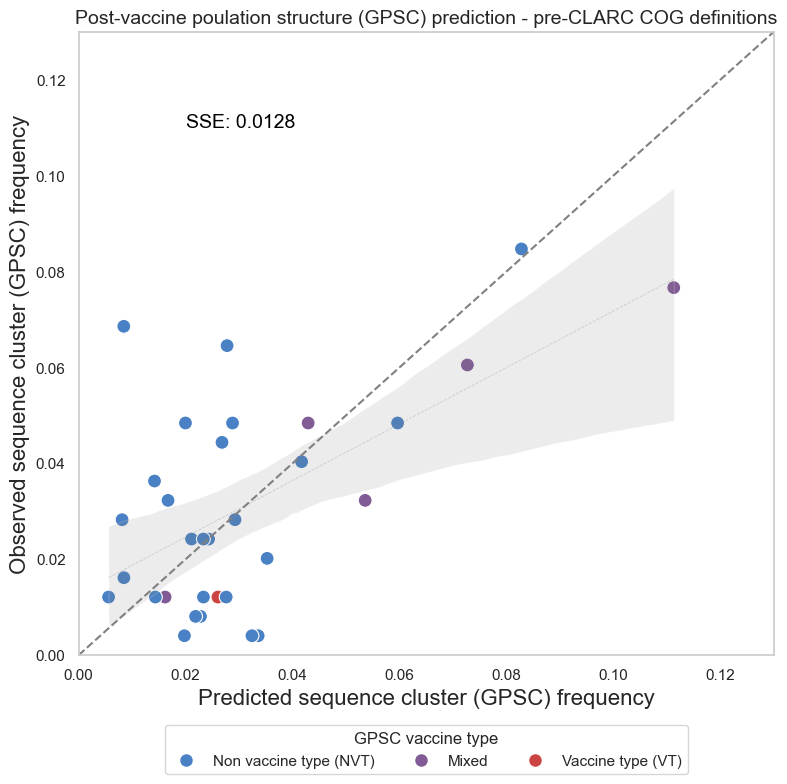

In [206]:
SSE_value = 0.0128
all_pred_table_roary['vaccine'] = all_pred_table_roary['vaccine'].fillna('VT')

vaccine_colors = {
    'mixed': '#815b95',
    'NVT': '#4981c4',
    'VT': '#cc4442',
}

sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))

scatter = sns.scatterplot(data=all_pred_table_roary, 
                          x='SC_pred', 
                          y='SC_obs', 
                          hue='vaccine',  
                          palette=vaccine_colors,  # Use the custom palette
                          s=100)

sns.regplot(data=all_pred_table_roary, 
            x='SC_pred', 
            y='SC_obs', 
            scatter=False, 
            color='gray', 
            line_kws={'linestyle': '--', 'linewidth': 0.6, 'alpha': 0.3})

plt.plot([0, 0.13], [0, 0.13], ls="--", c="gray")

plt.grid(False)
plt.xlabel('Predicted sequence cluster (GPSC) frequency', fontsize=16)
plt.ylabel('Observed sequence cluster (GPSC) frequency', fontsize=16)
plt.title('Post-vaccine poulation structure (GPSC) prediction - pre-CLARC COG definitions', fontsize=14)

plt.text(0.02, 0.11, f'SSE: {SSE_value:.4f}', fontsize=14, color='black')

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Non vaccine type (NVT)', markerfacecolor=vaccine_colors['NVT'], markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Mixed', markerfacecolor=vaccine_colors['mixed'], markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Vaccine type (VT)', markerfacecolor=vaccine_colors['VT'], markersize=10),
]

plt.legend(title='GPSC vaccine type', handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=23)

plt.xlim([0, 0.13])
plt.ylim([0, 0.13])
plt.tight_layout()

plt.show()

## Figure 6B: Post-vaccine population structure prediction with Roary+CLARC output

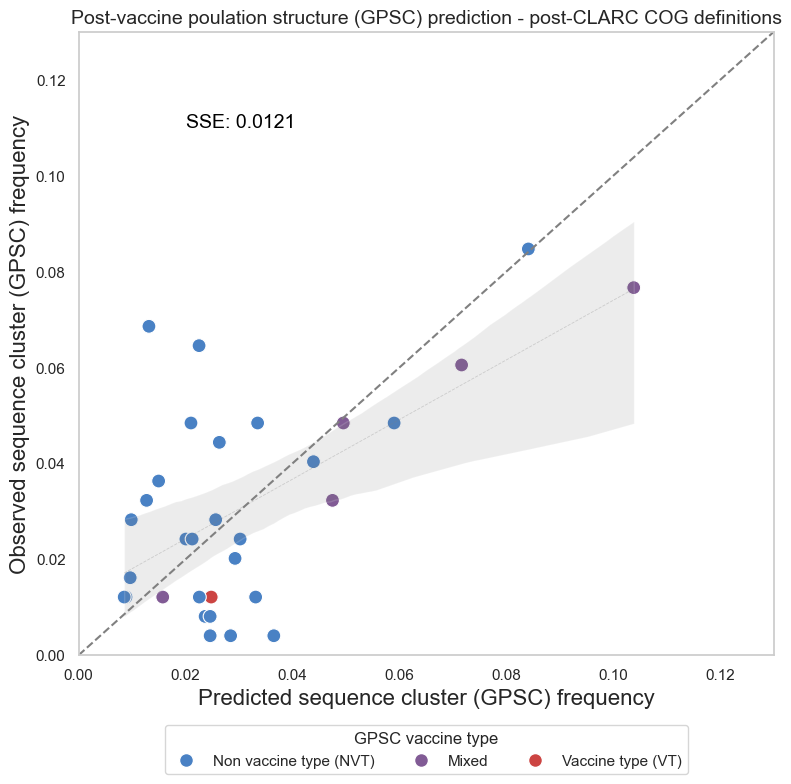

In [205]:
SSE_value = 0.0121
all_pred_table_clarc['vaccine'] = all_pred_table_clarc['vaccine'].fillna('VT')

vaccine_colors = {
    'mixed': '#815b95',
    'NVT': '#4981c4',
    'VT': '#cc4442',
}

sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))

scatter = sns.scatterplot(data=all_pred_table_clarc, 
                          x='SC_pred', 
                          y='SC_obs', 
                          hue='vaccine',  
                          palette=vaccine_colors,  # Use the custom palette
                          s=100)

sns.regplot(data=all_pred_table_clarc, 
            x='SC_pred', 
            y='SC_obs', 
            scatter=False, 
            color='gray', 
            line_kws={'linestyle': '--', 'linewidth': 0.6, 'alpha': 0.3})

plt.plot([0, 0.13], [0, 0.13], ls="--", c="gray")

plt.grid(False)
plt.xlabel('Predicted sequence cluster (GPSC) frequency', fontsize=16)
plt.ylabel('Observed sequence cluster (GPSC) frequency', fontsize=16)
plt.title('Post-vaccine poulation structure (GPSC) prediction - post-CLARC COG definitions', fontsize=14)

plt.text(0.02, 0.11, f'SSE: {SSE_value:.4f}', fontsize=14, color='black')

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Non vaccine type (NVT)', markerfacecolor=vaccine_colors['NVT'], markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Mixed', markerfacecolor=vaccine_colors['mixed'], markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Vaccine type (VT)', markerfacecolor=vaccine_colors['VT'], markersize=10),
]

plt.legend(title='GPSC vaccine type', handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=23)

plt.xlim([0, 0.13])
plt.ylim([0, 0.13])
plt.tight_layout()

plt.show()

## Figure 6C: Random bootstrap to evaluate significance of the prediction error change

In [274]:
# Test with n random COGs
test = SSE_rand(2393,500)

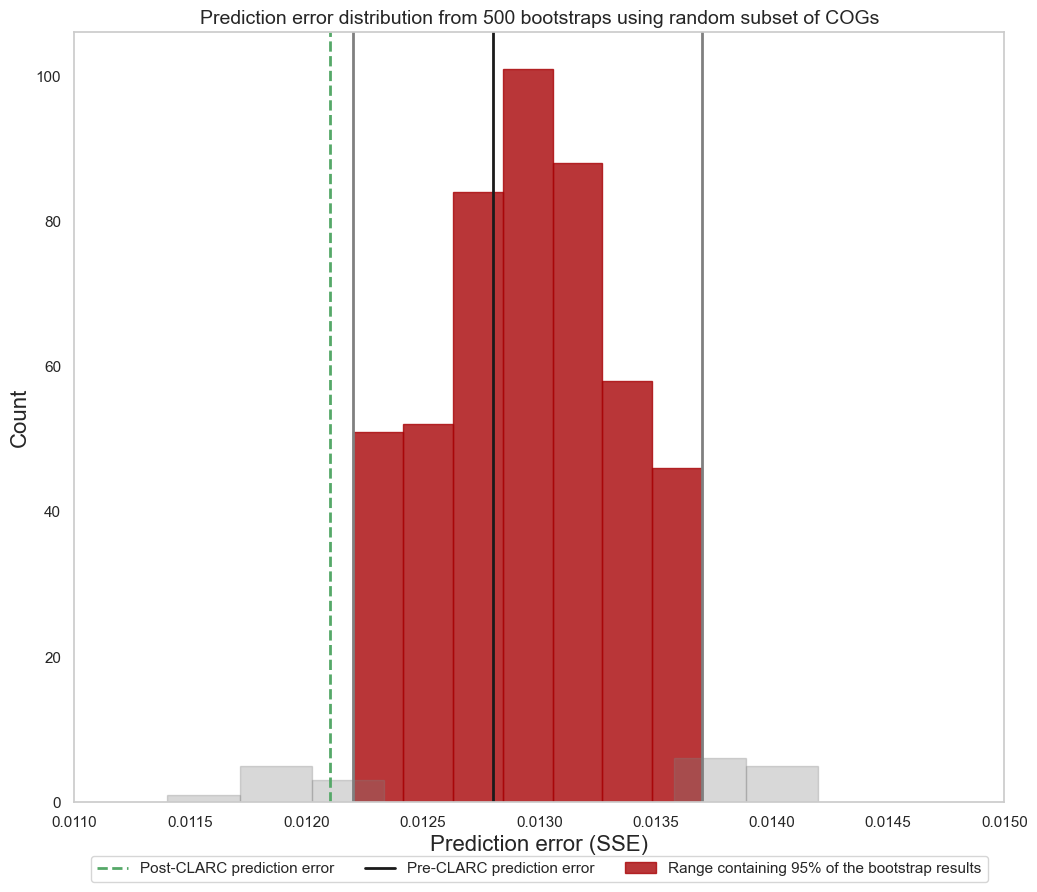

95% of the data is between 0.01220 and 0.01370


In [275]:
x = all_SSE
sx = str(x)

test = np.array(test)

lower_limit = np.percentile(test, 2.5)
upper_limit = np.percentile(test, 97.5)

plt.rcParams['figure.figsize'] = [12, 10]

within_percentile = (test >= lower_limit) & (test <= upper_limit)
outside_percentile = ~within_percentile

bins_within = np.linspace(lower_limit, upper_limit, 8) 
bins_outside = np.linspace(np.min(test), np.max(test), 10)

plt.axvline(0.0121, color='g', linestyle='dashed', linewidth=2, label='Post-CLARC prediction error')
plt.axvline(x, color='k', linewidth=2, label='Pre-CLARC prediction error')

plt.hist(test[within_percentile], bins=bins_within, color='#A80306', alpha=0.8, edgecolor='#A80306', label='Range containing 95% of the bootstrap results')

plt.hist(test[outside_percentile], bins=bins_outside, color='gray', alpha=0.3, edgecolor='gray')

plt.title('Prediction error distribution from 500 bootstraps using random subset of COGs', fontsize=14)
plt.xlabel('Prediction error (SSE)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0.011, 0.015])

plt.axvline(lower_limit, color='gray', linewidth=2)
plt.axvline(upper_limit, color='gray', linewidth=2)

min_ylim, max_ylim = plt.ylim()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=3)
plt.grid(False)

plt.show()

print(f"95% of the data is between {lower_limit:.5f} and {upper_limit:.5f}")

## Figure 6D: QP prediction improvement with different roary parameters

### Roary i90 QP prediction

In [255]:
#### Import data
acc_pres_abs_path = '~/population_accessory_presence_absence_i90.csv' # Presence absence files found at https://github.com/IndraGonz/2024_GonzalezOjeda_CLARC/tree/main/Figures/Fig6/data

# Import datafile with accessory gene info
pan_acc = pd.read_csv(acc_pres_abs_path, low_memory=False)

# Rename first column to Accession in the case of CLARC presence absence matrices
if pan_acc.columns[0] != 'Isolate Name':
    pan_acc.rename(columns={pan_acc.columns[0]: 'Isolate Name'}, inplace=True)

# Import metadata
meta = pd.read_csv('~/new_gpsc_metadata_MMN.csv')

# Add metadata to presence absence matrix
pan_acc = pd.merge(pan_acc, meta, on='Isolate Name')

# Get only Navajo dataset
navajo_pan_acc = pan_acc[pan_acc['Population']=='Navajo']

# Add vaccine type column
navajo_pan_acc.insert(7, 'PCV7_vaccine_type', "NVT")
# Determine vaccine using previously outlined cutoffs
navajo_pan_acc.loc[(navajo_pan_acc['serotype'] == '4') | (navajo_pan_acc['serotype'] == '6A') | (navajo_pan_acc['serotype'] == '6B') | (navajo_pan_acc['serotype'] == '9V') | (navajo_pan_acc['serotype'] == '14') | (navajo_pan_acc['serotype'] == '18C') | (navajo_pan_acc['serotype'] == '19F') | (navajo_pan_acc['serotype'] == '23F'), 'PCV7_vaccine_type'] = 'VT'

# Changing 'year' datatype to numeric, to do logical operations
navajo_pan_acc['Year of Isolation'] = navajo_pan_acc.loc[:,'Year of Isolation'].astype('int64')

# Add Epoch column
navajo_pan_acc.insert(4, 'epoch', " ")

# Determine epoch using previously outlined cutoffs
navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 1998) & (navajo_pan_acc['Year of Isolation'] <= 2001), 'epoch'] = 'E1'
navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 2006) & (navajo_pan_acc['Year of Isolation'] <= 2008), 'epoch'] = 'E2'
navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 2010) & (navajo_pan_acc['Year of Isolation'] <= 2012), 'epoch'] = 'E3'

# Get datasets per epoch
navajo_e1 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E1'].copy()
navajo_e2 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E2'].copy()
navajo_e3 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E3'].copy()

#### Preparing data for QP test

# Let's check which GPSCs are mixed, which are VT and which are NVT

# First let's sort by GPSC
navajo_all_gpsc = navajo_pan_acc.sort_values(by='GPSC')

# Now let's group by GPSC, and then loop through each group to see which GPSC are VT, NVT, or mixed
navajo_all_grouped_gpsc = navajo_pan_acc.groupby(['GPSC'])

# There is a total of 68 GPSCs in the Navajo dataset

# Next, checks if GPSC is mixed (contains both VT and NVT isolates). True = It is mixed, False = It is not mixed
navajo_all_gpsc_ismixed = navajo_pan_acc.groupby(['GPSC']).PCV7_vaccine_type.apply(lambda x: len(set(x)) != 1)

# There are 61 pure GPSCs and 7 mixed GPSCs accross all epochs

# Get mixed GPSCs
mixed_gpsc = navajo_all_gpsc_ismixed[navajo_all_gpsc_ismixed == True]
mixed_gpsc_list = list(mixed_gpsc.index)

# The mixed GPSCs are: 13, 16, 18, 6, 633, 7, 904;9

# 119 is VT

# Now let's group E3 by GPSC
navajo_e3_grouped_gpsc = navajo_e3.groupby(['GPSC'])

# What GPSCs appear at E3?
navajo_e3_gpsc_ismixed = navajo_e3.groupby(['GPSC']).PCV7_vaccine_type.apply(lambda x: len(set(x)) != 1)

# 43 GPSCs appear at E3

# Calculating M input for each population

# Now, let's calculate the observed COG frequencies per GPSC
# (this will be the first part of the input, of the population for which strain frequencies are being calculated)

# First we get rid of the unnecessary columns

# Navajo all epochs
navajo_all_f = navajo_pan_acc.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

# Navajo E1
navajo_e1_f = navajo_e1.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

#Navajo E2
navajo_e2_f = navajo_e2.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

#Navajo E3
navajo_e3_f = navajo_e3.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

# Now we determine the frequency of each COG per GPSC
#(and we transpose + sort by alphabetical order for consistency with QP function input)

# Important: Only the GPSCs that contain >5 isolates in the Navajo dataset to be predicted are being taken into account here, all others are dropped

# Navajo E1
navajo_e1_freq = navajo_e1_f.groupby(['GPSC']).mean()
navajo_e1_freq = navajo_e1_freq.transpose()
navajo_e1_freq = navajo_e1_freq.sort_index(axis=0)
navajo_e1_freq = navajo_e1_freq.reset_index()
navajo_e1_freq = navajo_e1_freq.rename(columns={"index": "COG_identifier"})
navajo_e1_freq = navajo_e1_freq.rename_axis(None, axis=1)

# Navajo E2
navajo_e2_freq = navajo_e2_f.groupby(['GPSC']).mean()
navajo_e2_freq = navajo_e2_freq.transpose()
navajo_e2_freq = navajo_e2_freq.sort_index(axis=0)
navajo_e2_freq = navajo_e2_freq.reset_index()
navajo_e2_freq = navajo_e2_freq.rename(columns={"index": "COG_identifier"})
navajo_e2_freq = navajo_e2_freq.rename_axis(None, axis=1)

# Navajo E3
navajo_e3_freq = navajo_e3_f.groupby(['GPSC']).mean()
navajo_e3_freq = navajo_e3_freq.transpose()
navajo_e3_freq = navajo_e3_freq.sort_index(axis=0)
navajo_e3_freq = navajo_e3_freq.reset_index()
navajo_e3_freq = navajo_e3_freq.rename(columns={"index": "COG_identifier"})
navajo_e3_freq = navajo_e3_freq.rename_axis(None, axis=1)

# Calculating E input for each population

# Now to determine global COG frequencies (not per strain)
# (this is the second input of the QP function, for the population that is being used to predict strain frequencies)

# Navajo E1
navajo_e1_gf = navajo_e1.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
navajo_e1_gfreq = navajo_e1_gf.mean()
navajo_e1_gfreq = navajo_e1_gfreq.sort_index(axis=0)

# Navajo E2
navajo_e2_gf = navajo_e2.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
navajo_e2_gfreq = navajo_e2_gf.mean()
navajo_e2_gfreq = navajo_e2_gfreq.sort_index(axis=0)

# Navajo E3
navajo_e3_gf = navajo_e3.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
navajo_e3_gfreq = navajo_e3_gf.mean()
navajo_e3_gfreq = navajo_e3_gfreq.sort_index(axis=0)

# Preparing the input for QP result plotting function (in each population)

# Finally, let's calculate the observed strain prevalences for each population
# (These are the values against which the QP predictions will be compared)
# To be input into the function, the output of the QP model must be appended to these dataframes under the name "SC_pred"

# Navajo all

# Only get GPSC info
navajo_all_gpsc = navajo_pan_acc[['GPSC']]

# Count number of isolates in each GPSC
navajo_all_gpscount = navajo_all_gpsc.groupby(['GPSC']).value_counts()
navajo_all_gpscount = navajo_all_gpscount.reset_index()
navajo_all_gpscount.columns = ["GPSC","GPSC_count"]

# Drop GPSCs that have 5 or less isolates
navajo_all_gpscount = navajo_all_gpscount.loc[navajo_all_gpscount["GPSC_count"] > 5 ]

# Get list of GPSCs with <= 5 isolates accross all epochs
navajo_over5_alle = list(navajo_all_gpscount['GPSC'])

# Get list of GPSCs at E3
navajo_e3_freq_index = navajo_e3_freq.set_index(navajo_e3_freq.columns[0])
navajo_gpsc_e3 = list(navajo_e3_freq_index.columns)

# Get intersect of these lists
navajo_e3_over5 = list(set(navajo_over5_alle) & set(navajo_gpsc_e3))

# Calculate frequencies

#Drop isolates not in the needed GPSCs
navajo_e3_need_gpsc = navajo_e3[navajo_e3.GPSC.isin(navajo_e3_over5)]

# Only get GPSC info
navajo_e3_gpsc = navajo_e3_need_gpsc[['GPSC']]

# Count number of isolates in each GPSC
navajo_e3_gpscount = navajo_e3_gpsc.groupby(['GPSC']).value_counts()
navajo_e3_gpscount = navajo_e3_gpscount.reset_index()
navajo_e3_gpscount.columns = ["GPSC","GPSC_count"]

# Now, calculate the frequency 
navajo_e3_total = navajo_e3_gpscount['GPSC_count'].sum()
navajo_e3_gpscount['GPSC_freq'] = navajo_e3_gpscount['GPSC_count']/navajo_e3_total

# Finally, create dataframe in the format that the QP plot function takes
pred_navajo_e3 = navajo_e3_gpscount.drop(columns=['GPSC_count'])
pred_navajo_e3.insert(1, 'vaccine', "NVT") # This is MEANINGLESS, it's not actually making a distinction between NVT, mixed and VT. But it needs to have this format to go into the function.
pred_navajo_e3 = pred_navajo_e3.rename(columns={"GPSC_freq": "SC_obs"})

# Switch the mixed GPSCs to mixed (these are 13, 16, 18, 6, 633, 7, 904;9)
rows_loop = pred_navajo_e3.shape[0]

for i in range(rows_loop):
    value = pred_navajo_e3.loc[i, 'GPSC']
    
    if value in mixed_gpsc_list:       
        pred_navajo_e3.loc[i, 'vaccine'] = 'mixed'

    if value == '119':
        pred_navajo_e3.loc[i, 'vaccine'] = np.nan

# Preparing for QP function - Dropping GPSC groups with < 5 isolates from M matrix

# Now, finally, since we are only predicting the GPSC with > 5 isolates in the predicted population
# we have to drop the GPSC with less than 5 isolated from the input COG frequency matrix

# For this, we take the list of names from the pred matrices and only keep those

# Navajo E3
navajo_e3_list = pred_navajo_e3.GPSC.values.tolist()
navajo_e3_freq_input = navajo_e3_freq[navajo_e3_freq.columns[navajo_e3_freq.columns.isin(navajo_e3_list)]]

# Add ID column to input vector (for COG subsetting)

## Let's try to manually prepare the input matrix with COG subset

# I have to manually add the ID column to the vector

# Navajo E3
navajo_e3_list = pred_navajo_e3.GPSC.values.tolist()
navajo_e3_list.append('COG_identifier')
navajo_e3_freq_input_id = navajo_e3_freq[navajo_e3_freq .columns[navajo_e3_freq .columns.isin(navajo_e3_list)]]

# Write additional python functions

# Function to subset data when trying to predict E3 from E1 values
def subset_input_E3_from_E1(subset):
    
    M = navajo_e3_freq_input_id
    E = navajo_e1_gfreq

    # Now, I take M and keep the COGs on the list, also drop identifier column
    M_subset = M[M.COG_identifier.isin(subset)]
    M_subset = M_subset.drop(columns=['COG_identifier'])

    # Likewise, I take E and remove the COGs on the list
    # Because I have E as a list, it needs to turn and unturn into a dataframe
    E = E.reset_index()
    E.columns = ["COG_identifier","E1_gfreq_observed"]
    E_subset = E[E.COG_identifier.isin(subset)]
    E_subset = E_subset.drop(columns=['COG_identifier'])

    return [M_subset,E_subset]

def SSE_rand(n,t):
    
    sse_random = []
    
    for x in range(t):
        
        # First let's get the subset COG list using my function
        subset = rand_COGlist(n)
        
        # Now, let's get the QP inputs with just the COG subsets
        [M_E3_subset, E_E1_subset] = subset_input_E3_from_E1(subset)
        
        # Then we switch the inputs to arrays
        M_E3_subset_array = M_E3_subset.to_numpy()
        E_E1_subset_array = E_E1_subset.to_numpy()
        
        # Run QP
        subset_E3fromE1_result = r_QP(M_E3_subset_array, E_E1_subset_array)
        
        # Add predicted GPSC prevalences to prediction matrix
        subset_E3_pred = pred_navajo_e3.copy()
        subset_E3_pred['SC_pred'] = subset_E3fromE1_result
        
        # Run SSEpred function to get SSE of the model
        SSE_subset_E3fromE1 = r_SSEpred(subset_E3_pred)
        result = SSE_subset_E3fromE1.item()
        # Append each loop
        sse_random.append(result)
        
    return(sse_random)

# Navajo E3 from E1

# Write function that inputs l = the list of specific COGs to try on the simulation and t = title of the plot
# it will returns the QP plot R object and the SSE value of that subset's fit

# This is also predicting E3 from E1

def target_subset_test(l,title):
    
    # Get inputs subsetted by the list
    [M_E3_subset,E_E1_subset] = subset_input_E3_from_E1(l)
    
    # Switch input to arrays
    M_E3_subset_array = M_E3_subset.to_numpy()
    E_E1_subset_array = E_E1_subset.to_numpy()
    
    # Run QP
    subset_E3fromE1_result = r_QP(M_E3_subset_array, E_E1_subset_array)

    # Add predicted GPSC prevalences to prediction matrix
    subset_E3_pred = pred_navajo_e3.copy()
    subset_E3_pred['SC_pred'] = subset_E3fromE1_result

    # Run plotPred to obtain plot
    subset_COGs_E3fromE1_plot = r_plotPred(subset_E3_pred, title)

    # Run SSEpred function to get SSE of the model
    SSE_subset_E3fromE1 = r_SSEpred(subset_E3_pred)
    sse_result = SSE_subset_E3fromE1.item()
    
    return [subset_COGs_E3fromE1_plot, sse_result, subset_E3_pred]

# Get the list of accessory COG names
navajo_e1_gfreq_names = navajo_e1_gfreq.reset_index()
navajo_e1_gfreq_names.columns = ["COG_identifier","E1_gfreq_observed"]

COG_names = list(navajo_e1_gfreq_names['COG_identifier'])

def rand_COGlist(n):
    
    COG_list = COG_names 
    COG_subset_list = random.sample(COG_names , n)
    
    return(COG_subset_list)

# Run QP test with set of all accessory COGs

all_num = len(COG_names)

# All eggnog COGs using subset function
title_all = f'GPSC prevalence prediction - E3 from E1 - {all_num} acc COGs'
[all_plot_roary_i90, all_SSE_roary_i90, all_pred_table_roary_i90] = target_subset_test(COG_names,title_all)

print('QP test SSE with the accessory COGs is: '+str(all_SSE_roary_i90))

QP test SSE with the accessory COGs is: 0.0131


In [256]:
# Test with n random COGs (so obviously all of them)
test = SSE_rand(2312,500)

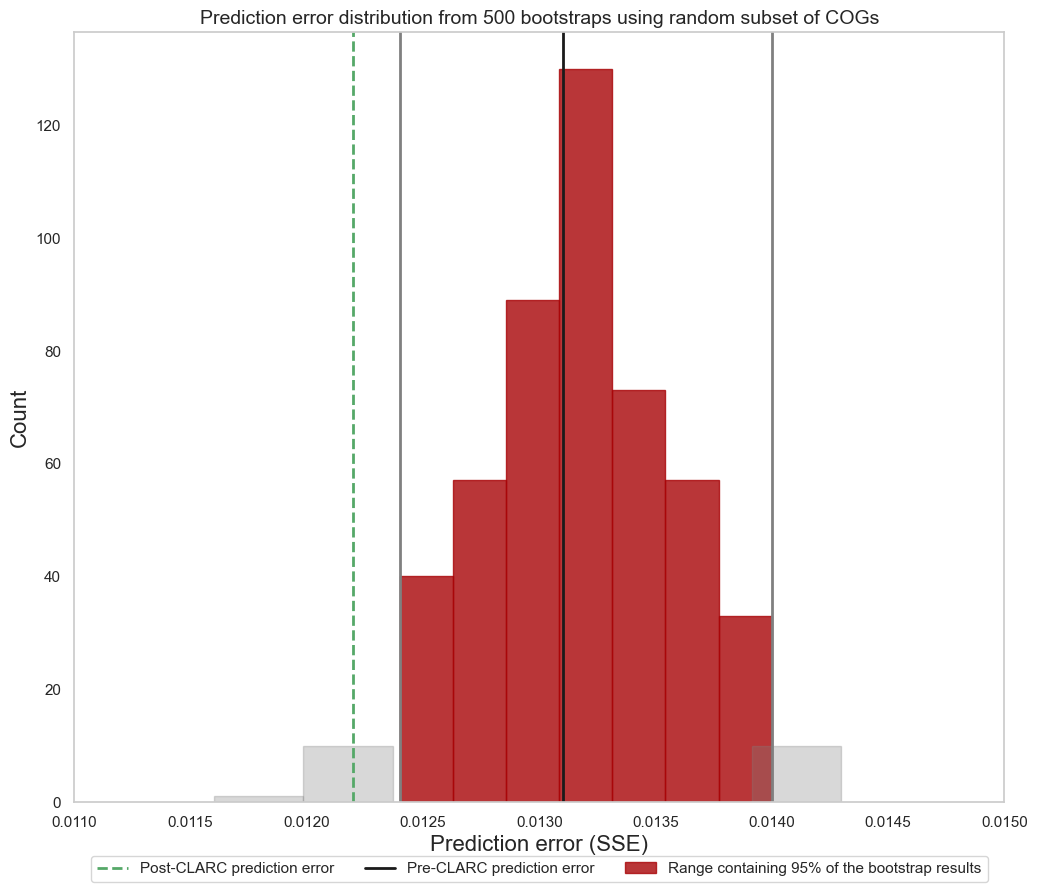

95% of the data is between 0.01240 and 0.01400


In [257]:
x = all_SSE_roary_i90
sx = str(x)

test = np.array(test)

lower_limit_i90 = np.percentile(test, 2.5)
upper_limit_i90 = np.percentile(test, 97.5)

plt.rcParams['figure.figsize'] = [12, 10]

within_percentile = (test >= lower_limit_i90) & (test <= upper_limit_i90)
outside_percentile = ~within_percentile

bins_within = np.linspace(lower_limit_i90, upper_limit_i90, 8) 
bins_outside = np.linspace(np.min(test), np.max(test), 8)

plt.axvline(0.0122, color='g', linestyle='dashed', linewidth=2, label='Post-CLARC prediction error')
plt.axvline(x, color='k', linewidth=2, label='Pre-CLARC prediction error')

plt.hist(test[within_percentile], bins=bins_within, color='#A80306', alpha=0.8, edgecolor='#A80306', label='Range containing 95% of the bootstrap results')

plt.hist(test[outside_percentile], bins=bins_outside, color='gray', alpha=0.3, edgecolor='gray')

plt.title('Prediction error distribution from 500 bootstraps using random subset of COGs', fontsize=14)
plt.xlabel('Prediction error (SSE)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0.011, 0.015])

plt.axvline(lower_limit_i90, color='gray', linewidth=2)
plt.axvline(upper_limit_i90, color='gray', linewidth=2)

min_ylim, max_ylim = plt.ylim()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=3)
plt.grid(False)

plt.show()

print(f"95% of the data is between {lower_limit_i90:.5f} and {upper_limit_i90:.5f}")

### Roary i80 QP prediction

In [215]:
#### Import data
acc_pres_abs_path = '~/population_accessory_presence_absence_i80.csv'

# Import datafile with accessory gene info
pan_acc = pd.read_csv(acc_pres_abs_path, low_memory=False)

# Rename first column to Accession in the case of CLARC presence absence matrices
if pan_acc.columns[0] != 'Isolate Name':
    pan_acc.rename(columns={pan_acc.columns[0]: 'Isolate Name'}, inplace=True)

# Import metadata
meta = pd.read_csv('~/new_gpsc_metadata_MMN.csv')

# Add metadata to presence absence matrix
pan_acc = pd.merge(pan_acc, meta, on='Isolate Name')

# Get only Navajo dataset
navajo_pan_acc = pan_acc[pan_acc['Population']=='Navajo']

# Add vaccine type column
navajo_pan_acc.insert(7, 'PCV7_vaccine_type', "NVT")
# Determine vaccine using previously outlined cutoffs
navajo_pan_acc.loc[(navajo_pan_acc['serotype'] == '4') | (navajo_pan_acc['serotype'] == '6A') | (navajo_pan_acc['serotype'] == '6B') | (navajo_pan_acc['serotype'] == '9V') | (navajo_pan_acc['serotype'] == '14') | (navajo_pan_acc['serotype'] == '18C') | (navajo_pan_acc['serotype'] == '19F') | (navajo_pan_acc['serotype'] == '23F'), 'PCV7_vaccine_type'] = 'VT'

# Changing 'year' datatype to numeric, to do logical operations
navajo_pan_acc['Year of Isolation'] = navajo_pan_acc.loc[:,'Year of Isolation'].astype('int64')

# Add Epoch column
navajo_pan_acc.insert(4, 'epoch', " ")

# Determine epoch using previously outlined cutoffs
navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 1998) & (navajo_pan_acc['Year of Isolation'] <= 2001), 'epoch'] = 'E1'
navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 2006) & (navajo_pan_acc['Year of Isolation'] <= 2008), 'epoch'] = 'E2'
navajo_pan_acc.loc[(navajo_pan_acc['Year of Isolation'] >= 2010) & (navajo_pan_acc['Year of Isolation'] <= 2012), 'epoch'] = 'E3'

# Get datasets per epoch
navajo_e1 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E1'].copy()
navajo_e2 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E2'].copy()
navajo_e3 = navajo_pan_acc.loc[navajo_pan_acc['epoch'] == 'E3'].copy()

#### Preparing data for QP test

# Let's check which GPSCs are mixed, which are VT and which are NVT

# First let's sort by GPSC
navajo_all_gpsc = navajo_pan_acc.sort_values(by='GPSC')

# Now let's group by GPSC, and then loop through each group to see which GPSC are VT, NVT, or mixed
navajo_all_grouped_gpsc = navajo_pan_acc.groupby(['GPSC'])

# There is a total of 68 GPSCs in the Navajo dataset

# Next, checks if GPSC is mixed (contains both VT and NVT isolates). True = It is mixed, False = It is not mixed
navajo_all_gpsc_ismixed = navajo_pan_acc.groupby(['GPSC']).PCV7_vaccine_type.apply(lambda x: len(set(x)) != 1)

# There are 61 pure GPSCs and 7 mixed GPSCs accross all epochs

# Get mixed GPSCs
mixed_gpsc = navajo_all_gpsc_ismixed[navajo_all_gpsc_ismixed == True]
mixed_gpsc_list = list(mixed_gpsc.index)

# The mixed GPSCs are: 13, 16, 18, 6, 633, 7, 904;9

# 119 is VT

# Now let's group E3 by GPSC
navajo_e3_grouped_gpsc = navajo_e3.groupby(['GPSC'])

# What GPSCs appear at E3?
navajo_e3_gpsc_ismixed = navajo_e3.groupby(['GPSC']).PCV7_vaccine_type.apply(lambda x: len(set(x)) != 1)

# 43 GPSCs appear at E3

# Calculating M input for each population

# Now, let's calculate the observed COG frequencies per GPSC
# (this will be the first part of the input, of the population for which strain frequencies are being calculated)

# First we get rid of the unnecessary columns

# Navajo all epochs
navajo_all_f = navajo_pan_acc.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

# Navajo E1
navajo_e1_f = navajo_e1.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

#Navajo E2
navajo_e2_f = navajo_e2.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

#Navajo E3
navajo_e3_f = navajo_e3.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name'])

# Now we determine the frequency of each COG per GPSC
#(and we transpose + sort by alphabetical order for consistency with QP function input)

# Important: Only the GPSCs that contain >5 isolates in the Navajo dataset to be predicted are being taken into account here, all others are dropped

# Navajo E1
navajo_e1_freq = navajo_e1_f.groupby(['GPSC']).mean()
navajo_e1_freq = navajo_e1_freq.transpose()
navajo_e1_freq = navajo_e1_freq.sort_index(axis=0)
navajo_e1_freq = navajo_e1_freq.reset_index()
navajo_e1_freq = navajo_e1_freq.rename(columns={"index": "COG_identifier"})
navajo_e1_freq = navajo_e1_freq.rename_axis(None, axis=1)

# Navajo E2
navajo_e2_freq = navajo_e2_f.groupby(['GPSC']).mean()
navajo_e2_freq = navajo_e2_freq.transpose()
navajo_e2_freq = navajo_e2_freq.sort_index(axis=0)
navajo_e2_freq = navajo_e2_freq.reset_index()
navajo_e2_freq = navajo_e2_freq.rename(columns={"index": "COG_identifier"})
navajo_e2_freq = navajo_e2_freq.rename_axis(None, axis=1)

# Navajo E3
navajo_e3_freq = navajo_e3_f.groupby(['GPSC']).mean()
navajo_e3_freq = navajo_e3_freq.transpose()
navajo_e3_freq = navajo_e3_freq.sort_index(axis=0)
navajo_e3_freq = navajo_e3_freq.reset_index()
navajo_e3_freq = navajo_e3_freq.rename(columns={"index": "COG_identifier"})
navajo_e3_freq = navajo_e3_freq.rename_axis(None, axis=1)

# Calculating E input for each population

# Now to determine global COG frequencies (not per strain)
# (this is the second input of the QP function, for the population that is being used to predict strain frequencies)

# Navajo E1
navajo_e1_gf = navajo_e1.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
navajo_e1_gfreq = navajo_e1_gf.mean()
navajo_e1_gfreq = navajo_e1_gfreq.sort_index(axis=0)

# Navajo E2
navajo_e2_gf = navajo_e2.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
navajo_e2_gfreq = navajo_e2_gf.mean()
navajo_e2_gfreq = navajo_e2_gfreq.sort_index(axis=0)

# Navajo E3
navajo_e3_gf = navajo_e3.drop(columns=['epoch','serotype','Year of Isolation','PCV7_vaccine_type','Accession Code','Population', 'Isolate Name', 'GPSC'])
navajo_e3_gfreq = navajo_e3_gf.mean()
navajo_e3_gfreq = navajo_e3_gfreq.sort_index(axis=0)

# Preparing the input for QP result plotting function (in each population)

# Finally, let's calculate the observed strain prevalences for each population
# (These are the values against which the QP predictions will be compared)
# To be input into the function, the output of the QP model must be appended to these dataframes under the name "SC_pred"

# Navajo all

# Only get GPSC info
navajo_all_gpsc = navajo_pan_acc[['GPSC']]

# Count number of isolates in each GPSC
navajo_all_gpscount = navajo_all_gpsc.groupby(['GPSC']).value_counts()
navajo_all_gpscount = navajo_all_gpscount.reset_index()
navajo_all_gpscount.columns = ["GPSC","GPSC_count"]

# Drop GPSCs that have 5 or less isolates
navajo_all_gpscount = navajo_all_gpscount.loc[navajo_all_gpscount["GPSC_count"] > 5 ]

# Get list of GPSCs with <= 5 isolates accross all epochs
navajo_over5_alle = list(navajo_all_gpscount['GPSC'])

# Get list of GPSCs at E3
navajo_e3_freq_index = navajo_e3_freq.set_index(navajo_e3_freq.columns[0])
navajo_gpsc_e3 = list(navajo_e3_freq_index.columns)

# Get intersect of these lists
navajo_e3_over5 = list(set(navajo_over5_alle) & set(navajo_gpsc_e3))

# Calculate frequencies

#Drop isolates not in the needed GPSCs
navajo_e3_need_gpsc = navajo_e3[navajo_e3.GPSC.isin(navajo_e3_over5)]

# Only get GPSC info
navajo_e3_gpsc = navajo_e3_need_gpsc[['GPSC']]

# Count number of isolates in each GPSC
navajo_e3_gpscount = navajo_e3_gpsc.groupby(['GPSC']).value_counts()
navajo_e3_gpscount = navajo_e3_gpscount.reset_index()
navajo_e3_gpscount.columns = ["GPSC","GPSC_count"]

# Now, calculate the frequency 
navajo_e3_total = navajo_e3_gpscount['GPSC_count'].sum()
navajo_e3_gpscount['GPSC_freq'] = navajo_e3_gpscount['GPSC_count']/navajo_e3_total

# Finally, create dataframe in the format that the QP plot function takes
pred_navajo_e3 = navajo_e3_gpscount.drop(columns=['GPSC_count'])
pred_navajo_e3.insert(1, 'vaccine', "NVT") # This is MEANINGLESS, it's not actually making a distinction between NVT, mixed and VT. But it needs to have this format to go into the function.
pred_navajo_e3 = pred_navajo_e3.rename(columns={"GPSC_freq": "SC_obs"})

# Switch the mixed GPSCs to mixed (these are 13, 16, 18, 6, 633, 7, 904;9)
rows_loop = pred_navajo_e3.shape[0]

for i in range(rows_loop):
    value = pred_navajo_e3.loc[i, 'GPSC']
    
    if value in mixed_gpsc_list:       
        pred_navajo_e3.loc[i, 'vaccine'] = 'mixed'

    if value == '119':
        pred_navajo_e3.loc[i, 'vaccine'] = np.nan

# Preparing for QP function - Dropping GPSC groups with < 5 isolates from M matrix

# Now, finally, since we are only predicting the GPSC with > 5 isolates in the predicted population
# we have to drop the GPSC with less than 5 isolated from the input COG frequency matrix

# For this, we take the list of names from the pred matrices and only keep those

# Navajo E3
navajo_e3_list = pred_navajo_e3.GPSC.values.tolist()
navajo_e3_freq_input = navajo_e3_freq[navajo_e3_freq.columns[navajo_e3_freq.columns.isin(navajo_e3_list)]]

# Add ID column to input vector (for COG subsetting)

## Let's try to manually prepare the input matrix with COG subset

# I have to manually add the ID column to the vector

# Navajo E3
navajo_e3_list = pred_navajo_e3.GPSC.values.tolist()
navajo_e3_list.append('COG_identifier')
navajo_e3_freq_input_id = navajo_e3_freq[navajo_e3_freq .columns[navajo_e3_freq .columns.isin(navajo_e3_list)]]

# Write additional python functions

# Function to subset data when trying to predict E3 from E1 values
def subset_input_E3_from_E1(subset):
    
    M = navajo_e3_freq_input_id
    E = navajo_e1_gfreq

    # Now, I take M and keep the COGs on the list, also drop identifier column
    M_subset = M[M.COG_identifier.isin(subset)]
    M_subset = M_subset.drop(columns=['COG_identifier'])

    # Likewise, I take E and remove the COGs on the list
    # Because I have E as a list, it needs to turn and unturn into a dataframe
    E = E.reset_index()
    E.columns = ["COG_identifier","E1_gfreq_observed"]
    E_subset = E[E.COG_identifier.isin(subset)]
    E_subset = E_subset.drop(columns=['COG_identifier'])

    return [M_subset,E_subset]

def SSE_rand(n,t):
    
    sse_random = []
    
    for x in range(t):
        
        # First let's get the subset COG list using my function
        subset = rand_COGlist(n)
        
        # Now, let's get the QP inputs with just the COG subsets
        [M_E3_subset, E_E1_subset] = subset_input_E3_from_E1(subset)
        
        # Then we switch the inputs to arrays
        M_E3_subset_array = M_E3_subset.to_numpy()
        E_E1_subset_array = E_E1_subset.to_numpy()
        
        # Run QP
        subset_E3fromE1_result = r_QP(M_E3_subset_array, E_E1_subset_array)
        
        # Add predicted GPSC prevalences to prediction matrix
        subset_E3_pred = pred_navajo_e3.copy()
        subset_E3_pred['SC_pred'] = subset_E3fromE1_result
        
        # Run SSEpred function to get SSE of the model
        SSE_subset_E3fromE1 = r_SSEpred(subset_E3_pred)
        result = SSE_subset_E3fromE1.item()
        # Append each loop
        sse_random.append(result)
        
    return(sse_random)

# Navajo E3 from E1

# Write function that inputs l = the list of specific COGs to try on the simulation and t = title of the plot
# it will returns the QP plot R object and the SSE value of that subset's fit

# This is also predicting E3 from E1

def target_subset_test(l,title):
    
    # Get inputs subsetted by the list
    [M_E3_subset,E_E1_subset] = subset_input_E3_from_E1(l)
    
    # Switch input to arrays
    M_E3_subset_array = M_E3_subset.to_numpy()
    E_E1_subset_array = E_E1_subset.to_numpy()
    
    # Run QP
    subset_E3fromE1_result = r_QP(M_E3_subset_array, E_E1_subset_array)

    # Add predicted GPSC prevalences to prediction matrix
    subset_E3_pred = pred_navajo_e3.copy()
    subset_E3_pred['SC_pred'] = subset_E3fromE1_result

    # Run plotPred to obtain plot
    subset_COGs_E3fromE1_plot = r_plotPred(subset_E3_pred, title)

    # Run SSEpred function to get SSE of the model
    SSE_subset_E3fromE1 = r_SSEpred(subset_E3_pred)
    sse_result = SSE_subset_E3fromE1.item()
    
    return [subset_COGs_E3fromE1_plot, sse_result, subset_E3_pred]

# Get the list of accessory COG names
navajo_e1_gfreq_names = navajo_e1_gfreq.reset_index()
navajo_e1_gfreq_names.columns = ["COG_identifier","E1_gfreq_observed"]

COG_names = list(navajo_e1_gfreq_names['COG_identifier'])

def rand_COGlist(n):
    
    COG_list = COG_names 
    COG_subset_list = random.sample(COG_names , n)
    
    return(COG_subset_list)

# Run QP test with set of all accessory COGs

all_num = len(COG_names)

# All eggnog COGs using subset function
title_all = f'GPSC prevalence prediction - E3 from E1 - {all_num} acc COGs'
[all_plot_roary_i80, all_SSE_roary_i80, all_pred_table_roary_i80] = target_subset_test(COG_names,title_all)

print('QP test SSE with the accessory COGs is: '+str(all_SSE_roary_i80))

QP test SSE with the accessory COGs is: 0.0133


In [234]:
# Test with n random COGs (so obviously all of them)
test = SSE_rand(2324,1000)

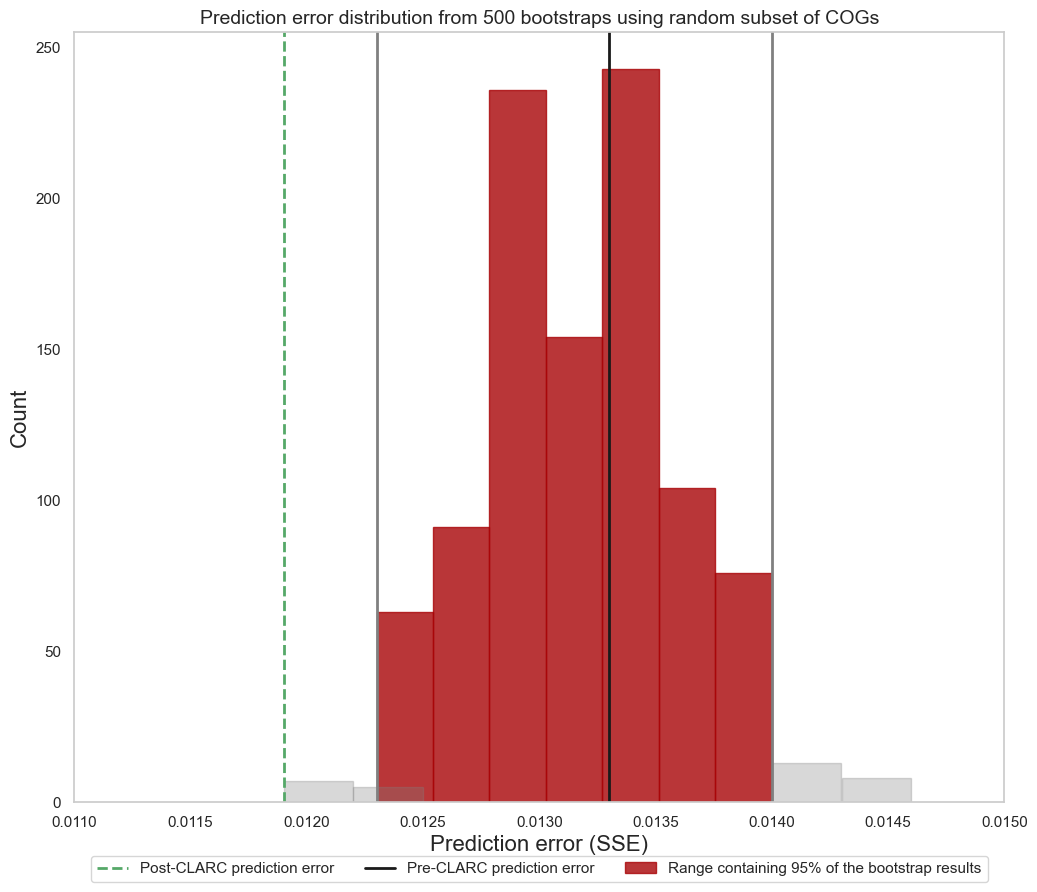

95% of the data is between 0.01230 and 0.01400


In [235]:
x = all_SSE_roary_i80
sx = str(x)

test = np.array(test)

lower_limit_i80 = np.percentile(test, 2.5)
upper_limit_i80 = np.percentile(test, 97.5)

plt.rcParams['figure.figsize'] = [12, 10]

within_percentile = (test >= lower_limit_i80) & (test <= upper_limit_i80)
outside_percentile = ~within_percentile

bins_within = np.linspace(lower_limit_i80, upper_limit_i80, 8) 
bins_outside = np.linspace(np.min(test), np.max(test), 10)

plt.axvline(0.0119, color='g', linestyle='dashed', linewidth=2, label='Post-CLARC prediction error')
plt.axvline(x, color='k', linewidth=2, label='Pre-CLARC prediction error')

plt.hist(test[within_percentile], bins=bins_within, color='#A80306', alpha=0.8, edgecolor='#A80306', label='Range containing 95% of the bootstrap results')

plt.hist(test[outside_percentile], bins=bins_outside, color='gray', alpha=0.3, edgecolor='gray')

plt.title('Prediction error distribution from 500 bootstraps using random subset of COGs', fontsize=14)
plt.xlabel('Prediction error (SSE)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0.011, 0.015])

plt.axvline(lower_limit_i80, color='gray', linewidth=2)
plt.axvline(upper_limit_i80, color='gray', linewidth=2)

min_ylim, max_ylim = plt.ylim()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=3)
plt.grid(False)

plt.show()

print(f"95% of the data is between {lower_limit_i80:.5f} and {upper_limit_i80:.5f}")

In [ ]:
roary_identity = [0.95, 0.90, 0.80]
roary_qp_sse = [roary_i95_qp_results_mass.iloc[6]['roary_sw_qp_sse'], roary_i90_qp_results_mass.iloc[6]['roary_sw_qp_sse'], roary_i80_qp_results_mass.iloc[6]['roary_sw_qp_sse']]
clarc_qp_sse = [roary_i95_qp_results_mass.iloc[6]['clarc_sw_qp_sse'], roary_i90_qp_results_mass.iloc[6]['clarc_sw_qp_sse'], roary_i80_qp_results_mass.iloc[6]['clarc_sw_qp_sse']]

#shapes = ['o', 's', 'D']  # circle, square, diamond
colors = ['#543005', '#8c510a', '#bf812d']
#sizes = [100, 200, 300]

# Create the scatter plot
plt.figure(figsize=(10, 6))
for i in range(len(roary_identity)):
    plt.scatter(roary_identity[i], roary_qp_sse[i], marker='o', color=colors[i], s=100)
    plt.scatter(roary_identity[i], clarc_qp_sse[i], marker='D', color=colors[i], s=100)

# Add labels and title
plt.xlabel('Roary identity threshold')
plt.ylabel('QP prediction SSE')
plt.title('Error in QP prediction pre and post CLARC - all carriage pangenomes')
plt.grid(True)

# Show the plot
plt.show()

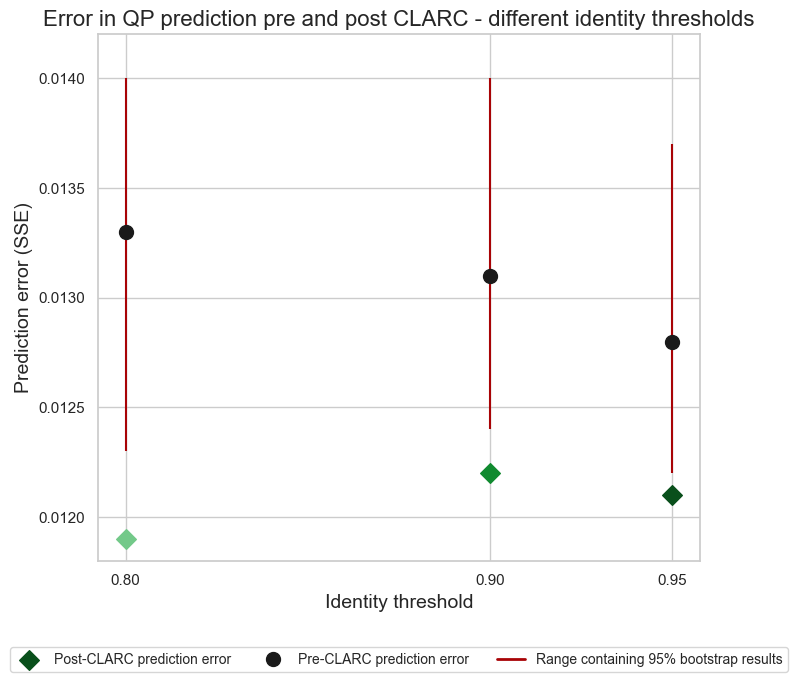

In [309]:
roary_identity = [0.95, 0.90, 0.80]
roary_qp_sse = [
    roary_i95_qp_results_mass.iloc[6]['roary_sw_qp_sse'], 
    roary_i90_qp_results_mass.iloc[6]['roary_sw_qp_sse'], 
    roary_i80_qp_results_mass.iloc[6]['roary_sw_qp_sse']
]
clarc_qp_sse = [
    roary_i95_qp_results_mass.iloc[6]['clarc_sw_qp_sse'], 
    roary_i90_qp_results_mass.iloc[6]['clarc_sw_qp_sse'], 
    roary_i80_qp_results_mass.iloc[6]['clarc_sw_qp_sse']
]

# Define lower and upper thresholds for each identity
roary_qp_lower = [lower_limit, lower_limit_i90, lower_limit_i80]  # Lower thresholds
roary_qp_upper = [upper_limit, upper_limit_i90, upper_limit_i80]  # Upper thresholds

# Calculate the lengths for the error bars
roary_qp_errors_lower = np.array(roary_qp_sse) - np.array(roary_qp_lower)  # Lower errors
roary_qp_errors_upper = np.array(roary_qp_upper) - np.array(roary_qp_sse)  # Upper errors

# Define colors for Roary and CLARC points
roary_colors = ['k', 'k', 'k']  # Colors for Roary points
clarc_colors = ['#094f1b', '#108a2f', '#73c989']  # Colors for CLARC points

plt.figure(figsize=(8, 7))
plt.ylim([0.0118, 0.0142])
error_bar_color = '#A80306'

for i in range(len(roary_identity)):
    
    # Plot roary_qp_sse with error bars
    plt.errorbar(roary_identity[i], roary_qp_sse[i], 
                 yerr=[[roary_qp_errors_lower[i]], [roary_qp_errors_upper[i]]],  # 2D array for lower and upper errors
                 fmt='o', color=roary_colors[i], ecolor=error_bar_color, markersize=10, label='Pre-CLARC prediction error' if i == 0 else "")

    # Plot clarc_qp_sse as diamonds
    plt.scatter(roary_identity[i], clarc_qp_sse[i], marker='D', color=clarc_colors[i], s=100, 
                label='Post-CLARC prediction error' if i == 0 else "")


plt.axhline(y=0, color='#A80306', linestyle='-', linewidth=1) 
gray_line = mlines.Line2D([], [], color='#A80306', label='Range containing 95% bootstrap results', linewidth=2)
handles = plt.gca().get_legend_handles_labels()[0]  
handles.append(gray_line)  

plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize='small', ncol=3)

plt.xlabel('Identity threshold', fontsize=14)
plt.ylabel('Prediction error (SSE)', fontsize=14)
plt.title('Error in QP prediction pre and post CLARC - different identity thresholds', fontsize=16)
plt.grid(True)

plt.xticks(ticks=[0.80, 0.90, 0.95], labels=['0.80', '0.90', '0.95'])

plt.tight_layout()  

plt.show()